In [2]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #requires 3.4
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import pairwise_distances #igual a sklearn.neighbors.DistanceMetric
from scipy import stats
import scikit_posthocs as sp 
# from cobra.io import read_sbml_model

ROOT_FOLDER = "C:\\Users\\liamo\\Documents\\BIOINF\\PRETHESIS"
tissue_meta = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","metadata_clean.csv"),index_col=0,header=0)
tissue_meta_allrin = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","allrin6_metadata_clean.csv"),index_col=0,header=0)
new_tissues = ["Whole Blood","Stomach","Lung","Brain - Cortex","Muscle - Skeletal",
             "Pancreas","Colon - Transverse"] 
# OGMODEL_PATH = os.path.join(ROOT_FOLDER,"Human-GEM","model", "Human-GEM_ct.xml")
# XLS_MODEL_PATH = os.path.join(ROOT_FOLDER,"Human-GEM","model", "Human-GEM.xlsx")

- 40 sample test batches (n=10 per tissue) / full 212 batches (n=53 per tissue)
- Minimal and Protected core reactions (n=3 vs n=400+)
- consistent template model without drug exchange/demand reactions

In [3]:
def tasks_to_df(pddf):
    df = pd.DataFrame(np.zeros((pddf.shape[0],len(pddf.iloc[0,1].values()))))
    for row in range(pddf.shape[0]):
        line = list(pddf.iloc[row,1].values())
        line2 = []
        for lst in line: line2.append(lst[0])
        df.iloc[row,:] = line2
    return df

In [4]:
siglas = pd.read_excel(os.path.join(ROOT_FOLDER,"Human-GEM","data","metabolicTasks", 'metabolicTasks_Essential.xlsx')
                      ).iloc[0,1].split(";")

tdf = pd.read_excel(os.path.join(ROOT_FOLDER,"Human-GEM","data","metabolicTasks", 'metabolicTasks_Essential.xlsx'))
valid_tdf = tdf.loc[tdf.iloc[:, 0] != '#', :].iloc[:, 1:]

from collections import Counter
id_counter = Counter()

real_id = []
for i in valid_tdf['ID'].fillna(-1):
    if i != -1:
        id_counter[i] += 1
        real_id.append(str(i) + str(id_counter[i]))
    else:
        real_id.append(real_id[-1])
valid_tdf['ID'] = real_id

In [5]:
ess_tsks = valid_tdf.dropna(subset=["DESCRIPTION"]).sort_values("ID").reset_index().iloc[:,1:3]
ess_tsks.head()

,ID,DESCRIPTION
0,BS1,ATP de novo synthesis
1,BS10,Protein synthesis from AAs
2,BS11,Phosphatidylcholine de novo synthesis
3,BS12,Phosphatidylethanolamine de novo synthesis
4,BS13,Phosphatidylserine de novo synthesis


Task evaluation: Troppo VS MATLAB comparison

In [6]:
h1xml_ess_trp = pd.read_json(os.path.join(ROOT_FOLDER,"DATA","h1v1.5_tasks.json"))
h1xml_ess_trp[2] = [x[0] for x in h1xml_ess_trp[1]]
h1xml_ess_trp = h1xml_ess_trp.drop([1],axis=1)

h1xml_full_trp = pd.read_json(os.path.join(ROOT_FOLDER,"DATA","h1v1.5_full_tasks.json"))
h1xml_full_trp[2] = [x[0] for x in h1xml_full_trp[1]]
h1xml_full_trp = h1xml_full_trp.drop([1],axis=1)

h1xml_ess_mat = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","Human-GEMxml_essMAT.csv"),header=0,index_col=0)
h1xml_full_mat = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","Human-GEMxml_fullMAT.csv"),header=0,index_col=0)

In [7]:
print("Essential tasks: Troppo VS MATLAB")
print(h1xml_ess_trp[2].sum(),"vs",h1xml_ess_mat["ok"].sum())
print("Full tasks: Troppo VS MATLAB")
print(h1xml_full_trp[2].sum(),"vs",h1xml_full_mat["ok"].sum())
# print("out of:",h1xml_full_mat.shape[0])
# del h1xml_ess_trp,h1xml_full_trp,h1xml_ess_mat, h1xml_full_mat

Essential tasks: Troppo VS MATLAB
57 vs 57
Full tasks: Troppo VS MATLAB
241 vs 256


Template model task evaluation

In [8]:
template_ess = pd.read_json(os.path.join(ROOT_FOLDER,"DATA","h1v1.5ctnodrugex_ess.json"))
template_ess[2] = [x[0] for x in template_ess[1]]
template_ess = template_ess.drop([1],axis=1)

template_full = pd.read_json(os.path.join(ROOT_FOLDER,"DATA","h1v1.5ctnodrugex_full.json"))
template_full[2] = [x[0] for x in template_full[1]]
template_full = template_full.drop([1],axis=1)

In [65]:
# template_ess[2].sum()
print(template_ess.loc[template_ess[2]==False,:])
print(ess_tsks.loc[ess_tsks["ID"]=="BS15",:])

      0      2
6  BS15  False
     ID                     DESCRIPTION
6  BS15  Thiamin phosphorylation to TPP


### Reaction count VS Tasks passed

Minimal models

In [10]:
min_csm = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_fttinit_rin6_min_csm_nodrugex.csv"),
                          header=0,index_col=[0,1]).drop(["Unnamed: 2"], axis=1)
min_csm_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                      "gtl50_gtu90_lt50_fttinit_rin6_min_tasks_nodrugex.json")))
min_csm_tasks.index = min_csm.index

In [11]:
min_csm.shape

(80, 11386)

Protected reaction models

In [12]:
ft_prmat = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_ft_4tissues_rin6_prmat_csm_nodrugex.csv"),
                          header=0,index_col=1).drop(["Unnamed: 0", "Unnamed: 2"], axis=1)
ft_prmat_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                       "gtl50_gtu90_lt50_ft_4tissues_rin6_prmat_tasks_nodrugex.json")))
ft_prmat_tasks.index = ft_prmat.index
ft_prmat_tasks.columns = ess_tsks.iloc[:,1].to_list()

tinit_prmat = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_tinit_4tissues_rin6_prmat_csm_nodrugex.csv"),
                          header=0,index_col=1).drop(["Unnamed: 0", "Unnamed: 2"], axis=1)
tinit_prmat_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                          "gtl50_gtu90_lt50_tinit_4tissues_rin6_prmat_tasks_nodrugex.json")))
tinit_prmat_tasks.index = tinit_prmat.index
tinit_prmat_tasks.columns = ess_tsks.iloc[:,1].to_list()

ft_more = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_ft53_more_rin6_csm_nodrugex.csv"),
                          header=0,index_col=1).drop(["Unnamed: 0", "Unnamed: 2"], axis=1)
ft_more_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                       "gtl50_gtu90_lt50_ft53_more_rin6_tasks_nodrugex.json")))
ft_more_tasks.index = ft_more.index
ft_more_tasks.columns = ess_tsks.iloc[:,1].to_list()

tinit_more = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_tinit20_more_rin6_csm_nodrugex.csv"),
                          header=0,index_col=1).drop(["Unnamed: 0", "Unnamed: 2"], axis=1)
tinit_more_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                       "gtl50_gtu90_lt50_tinit20_more_rin6_tasks_nodrugex.json")))
tinit_more_tasks.index = tinit_more.index
tinit_more_tasks.columns = ess_tsks.iloc[:,1].to_list()

In [13]:
protected = list(pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","task_rcts_protected_mat.csv"), header=0)["ID"])
print("Protected reactions:",len(protected))
# print(len(set(ft_prmat.columns).intersection(set(protected)))) #all, no prob
# pd.concat((ft_prmat,tinit_prmat,ft_more,tinit_more)).loc[:,protected].all().all() #False
print("Protected reaction(s) not present in all models:",
      protected[np.where(pd.concat((ft_prmat,tinit_prmat,ft_more,tinit_more)).loc[:,protected].all()==False)[0][0]])

Protected reactions: 404
Protected reaction(s) not present in all models: HMR_5151


Robinson et al. models

In [14]:
all_tissues = ['adipose tissue', 'brain','breast', 'blood', 'colon', 'kidney', 'liver', 'lung', 
       'muscle', 'pancreas', 'stomach'] #not sorted for the task eval oops
h1_rc = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","H1_CSMS_RC_clean.csv"),header=0,index_col=0).loc[:,all_tissues].transpose()
extra_col = set(h1_rc.columns).difference(set(ft_prmat.columns)) 
# print(len(extra_col)) #1711? 1710

h1_rc_ess = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results","tINIT_GTEx_11esstasks.json")))
h1_rc_ess.index = h1_rc.index
h1_rc_ess.columns = ess_tsks["DESCRIPTION"].to_list()

In [15]:
h1_rc_ess_mat = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","H1_CSMS_11esstasks_MAT.csv"),header=None).transpose()
h1_rc_ess_mat.index = sorted(h1_rc.index)
h1_rc_ess_mat.columns = ess_tsks["DESCRIPTION"].to_list()
print(h1_rc_ess_mat.all().all())
# del h1_rc_ess_mat

True


In [16]:
h1_rc.sum(axis=1)

adipose tissue    7746
brain             7569
breast            7856
blood             6945
colon             7736
kidney            8164
liver             7946
lung              7860
muscle            6584
pancreas          7670
stomach           7292
dtype: int64

In [17]:
print(h1_rc_ess.sum(axis=1).value_counts(),end="\n\n")

56.0    10
55.0     1
dtype: int64



In [18]:
h1_rc_ess.loc[:,~h1_rc_ess.all()].transpose()

,adipose tissue,brain,breast,blood,colon,kidney,liver,lung,muscle,pancreas,stomach
Thiamin phosphorylation to TPP,False,False,False,False,False,False,False,False,False,False,False
Growth on Ham's media (biomass production),True,True,True,False,True,True,True,True,True,True,True


Prints

In [19]:
tissue_ids_max = {}
tissue_ids = []
for t in tissue_meta["Tissue"].unique():
    meta_indx = tissue_meta.iloc[np.where(tissue_meta["Tissue"] == t)[0], :].index 
    sp_t = np.where(ft_prmat.index.str.contains("|".join(
        list(meta_indx)), case=False, regex=True))[0][:10]
    tissue_ids.extend(sp_t)
    
    sp_max = np.where(ft_prmat.index.str.contains("|".join(
        list(meta_indx)), case=False, regex=True))[0][:53] #[:min(len(meta_indx),100)] 
    tissue_ids_max[t] = sp_max

In [20]:
print("Minimal models")
print("tinit reactions",min_csm.loc(axis=0)["tinit",:].sum(axis=1).mean())
print("fastcore reactions",min_csm.loc(axis=0)["fastcore",:].sum(axis=1).mean(),end="\n\n")
print("tinit tasks",min_csm_tasks.loc(axis=0)["tinit",:].sum(axis=1).mean())
print("fastcore tasks",min_csm_tasks.loc(axis=0)["fastcore",:].sum(axis=1).mean())

Minimal models
tinit reactions 7824.975
fastcore reactions 6321.825

tinit tasks 22.575
fastcore tasks 11.725


In [21]:
print("Same samples as minimal models")
# tinit_prmat.iloc[tissue_ids].index==min_csm.loc(axis=0)["tinit",:].index.get_level_values(1)
print("tinit reactions",tinit_prmat.iloc[tissue_ids].sum(axis=1).mean())
print("fastcore reactions",ft_prmat.iloc[tissue_ids].sum(axis=1).mean(),end="\n\n")
print("tinit tasks",tinit_prmat_tasks.iloc[tissue_ids].sum(axis=1).mean())
print("fastcore tasks",ft_prmat_tasks.iloc[tissue_ids].sum(axis=1).mean())

Same samples as minimal models
tinit reactions 7849.875
fastcore reactions 6329.675

tinit tasks 24.55
fastcore tasks 29.375


In [22]:
rctsk4=pd.concat((
    pd.concat((pd.concat((ft_prmat.sum(axis=1),tissue_meta.loc[ft_prmat.index,"Tissue"]),
          axis=1).groupby("Tissue").mean()[0],
    pd.concat((tinit_prmat.sum(axis=1),tissue_meta.loc[tinit_prmat.index,"Tissue"]),
          axis=1).groupby("Tissue").mean()[0]),axis=1,keys=["ft","tinit"]).round(2),
pd.concat((pd.concat((ft_prmat_tasks.sum(axis=1),tissue_meta.loc[ft_prmat.index,"Tissue"]),axis=1).groupby("Tissue").mean()[0],
    pd.concat((tinit_prmat_tasks.sum(axis=1),tissue_meta.loc[tinit_prmat.index,"Tissue"]),axis=1).groupby("Tissue").mean()[0]
),axis=1,keys=["ft","tinit"]).round(2) 
),axis=1,keys=["reactions","tasks"])

rctsk7=pd.concat((
    pd.concat(( pd.concat((ft_more.sum(axis=1),tissue_meta_allrin.loc[ft_more.index,"Tissue"]),
          axis=1).groupby("Tissue").mean()[0],
    pd.concat((tinit_more.sum(axis=1),tissue_meta_allrin.loc[tinit_more.index,"Tissue"]),
          axis=1).groupby("Tissue").mean()[0]),axis=1,keys=["ft","tinit"]).round(2),
pd.concat((pd.concat((ft_more_tasks.sum(axis=1),tissue_meta_allrin.loc[ft_more.index,"Tissue"]),
          axis=1).groupby("Tissue").mean()[0],
    pd.concat((tinit_more_tasks.sum(axis=1),tissue_meta_allrin.loc[tinit_more.index,"Tissue"]),axis=1).groupby("Tissue").mean()[0]
),axis=1,keys=["ft","tinit"]).round(2) 
),axis=1,keys=["reactions","tasks"])

pd.concat((rctsk4,rctsk7)).sort_index()

reactions           tasks       
                               ft    tinit     ft  tinit
Tissue                                                  
Adipose - Subcutaneous    6261.77  7922.21  34.08  30.70
Brain - Cortex            6165.57  7636.90  25.74  16.90
Breast - Mammary Tissue   6173.92  7857.08  32.09  30.57
Colon - Transverse        6880.38  8227.25  30.66  28.95
Kidney - Cortex           5793.26  7540.89  27.38  23.04
Liver                     6756.34  8051.47  25.94  17.98
Lung                      7544.42  8687.95  26.83  27.30
Muscle - Skeletal         5352.74  7509.45  25.68  17.65
Pancreas                  4919.25  6804.30  18.08  10.90
Stomach                   6549.66  8076.25  28.04  25.25
Whole Blood               4890.60  6865.90  15.53  12.25

In [23]:
print("ft > 6000 tasks",pd.concat((ft_prmat_tasks.sum(axis=1).loc[ft_prmat.sum(axis=1)>6000],
                                   ft_more_tasks.sum(axis=1).loc[ft_more.sum(axis=1)>6000])).mean())
print("tinit > 7000 tasks",pd.concat((tinit_prmat_tasks.sum(axis=1).loc[tinit_prmat.sum(axis=1)>6000],
                                      tinit_more_tasks.sum(axis=1).loc[tinit_more.sum(axis=1)>6000])).mean())

ft > 6000 tasks 29.548571428571428
tinit > 7000 tasks 23.356125356125357


In [24]:
print("Essential tasks failed by all TPM models:",
    ft_prmat_tasks.loc[:,(~ft_prmat_tasks.any())].columns.intersection(
    tinit_prmat_tasks.loc[:,(~tinit_prmat_tasks.any())].columns).intersection(
ft_more_tasks.loc[:,(~ft_more_tasks.any())].columns).intersection(
tinit_more_tasks.loc[:,(~tinit_more_tasks.any())].columns).to_list())

Essential tasks failed by all TPM models: ['Thiamin phosphorylation to TPP', "Growth on Ham's media (biomass production)"]


In [25]:
print("Reactions common to all TPM models:",(ft_prmat.all() & tinit_prmat.all() & ft_more.all() & tinit_more.all()).sum())
ft_prmat.columns[(ft_prmat.all() & tinit_prmat.all() & ft_more.all() & tinit_more.all())]

Reactions common to all TPM models: 709


Index(['HMR_4281', 'HMR_4355', 'HMR_4363', 'HMR_4371', 'HMR_4373', 'HMR_4375',
       'HMR_4396', 'HMR_4122', 'HMR_9727', 'HMR_8762',
       ...
       'GM1tl', 'HMR_10023', 'HMR_10024', 'HMR_10042', 'HMR_10043',
       'HMR_10062', 'HMR_10063', 'HMR_10064', 'HMR_10065', 'biomass_human'],
      dtype='object', length=709)

#### rc/AVERAGE ess tsks by tissue BARPLOT

In [26]:
tm_rc_temp = pd.concat((
pd.concat((ft_more.sum(axis=1).groupby(tissue_meta_allrin.loc[ft_more.index,"Tissue"]).mean(),
tinit_more.sum(axis=1).groupby(tissue_meta_allrin.loc[tinit_more.index,"Tissue"]).mean()
          ),axis=1,keys=["fastcore","tinit"]),
pd.concat((ft_prmat.sum(axis=1),tinit_prmat.sum(axis=1)),axis=1,
          keys=["fastcore","tinit"]).groupby(tissue_meta.loc[ft_prmat.index,"Tissue"]).mean()
),axis=0).round(2).sort_index()

tm_tsk_temp = pd.concat((
pd.concat((ft_more_tasks.sum(axis=1).groupby(tissue_meta_allrin.loc[ft_more.index,"Tissue"]).mean(),
tinit_more_tasks.sum(axis=1).groupby(tissue_meta_allrin.loc[tinit_more.index,"Tissue"]).mean()
          ),axis=1,keys=["fastcore","tinit"]),
pd.concat((ft_prmat_tasks.sum(axis=1),tinit_prmat_tasks.sum(axis=1)),axis=1,
          keys=["fastcore","tinit"]).groupby(tissue_meta.loc[ft_prmat.index,"Tissue"]).mean()
),axis=0).round(2).sort_index()

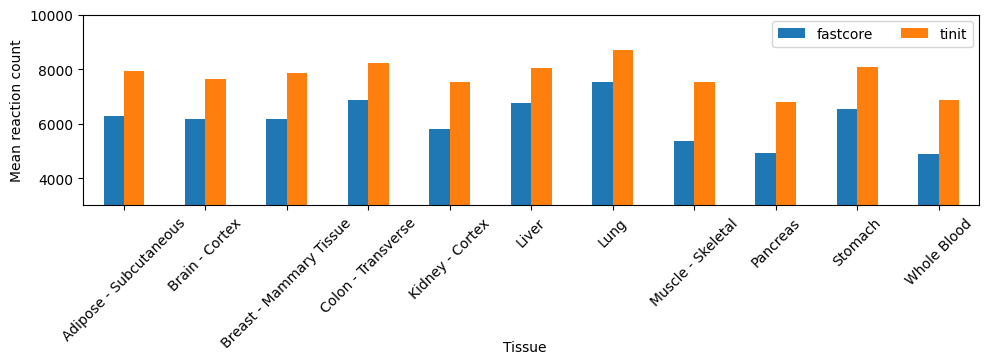

In [27]:
fig, ax = plt.subplots(figsize=(10,4)) #

tm_rc_temp.round(0).plot(kind="bar",ax=ax,legend=False)

ax.set_ylim(3000,10000) #(3000,10000)
ax.legend(ncol=2) #, markerscale=1.5
plt.xticks(rotation=45)
ax.set_ylabel("Mean reaction count")
ax.set_xlabel("")
fig.supxlabel("Tissue",x=0.53,y=0.1,fontsize="medium")
plt.tight_layout()
plt.show()

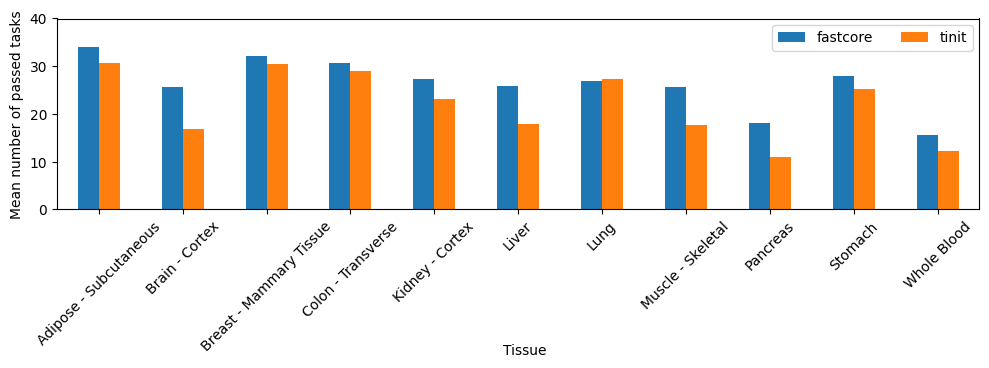

In [28]:
fig, ax = plt.subplots(figsize=(10,4)) #,sharey=True

# tm_rc_temp.plot(kind="bar",ax=ax[0],legend=False)
tm_tsk_temp.plot(kind="bar",ax=ax,legend=False)

ax.set_ylabel("Mean number of passed tasks")
ax.set_xlabel("")
fig.supxlabel("Tissue",x=0.53,y=0.1,fontsize="medium")
ax.set_ylim(0,40) #57
plt.setp(ax.get_xticklabels(), rotation=45) #plt.xticks(rotation=90)
ax.legend(ncol=2)

plt.tight_layout()
plt.show()

#### Grouped

In [29]:
grp = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_fttinit_median_by_TSAn4_csm_nodrugex.csv"),
                          header=0,index_col=1).drop(["Unnamed: 2"], axis=1)
grp.index = pd.MultiIndex.from_tuples([tuple(x.split("_")) for x in grp.index])
grp_tinit = grp.loc[grp["Unnamed: 0"]=="tinit",:].drop(["Unnamed: 0"], axis=1)
grp_ft = grp.loc[grp["Unnamed: 0"]=="fastcore",:].drop(["Unnamed: 0"], axis=1)

grp_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                        "gtl50_gtu90_lt50_fttinit_median_by_TSAn4_tasks_nodrugex.json")))
grp_tasks.index = grp.index
grp_tasks_tinit = grp_tasks.loc[grp["Unnamed: 0"]=="tinit",:]
grp_tasks_ft = grp_tasks.loc[grp["Unnamed: 0"]=="fastcore",:]

In [30]:
# grp_more1 = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_tinit14_median_by_TSAn7_csm_nodrugex.csv"),
#                           header=0,index_col=1).drop(["Unnamed: 0","Unnamed: 2"], axis=1)
# grp_more2 = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_tinit14-28_median_by_TSAn7_csm_nodrugex.csv"),
#                           header=0,index_col=1).drop(["Unnamed: 0","Unnamed: 2"], axis=1)
# grp_more3 = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_tinit28-42_median_by_TSAn7_csm_nodrugex.csv"),
#                           header=0,index_col=1).drop(["Unnamed: 0","Unnamed: 2"], axis=1) #

# grp_tinit_more = pd.concat((grp_more1,grp_more2,grp_more3),axis=0)
# grp_tinit_more.to_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_tinit_median_by_TSAn7_csm_nodrugex.csv"))

In [31]:
# pd.concat((grp_ft.sum(axis=1).unstack(),grp_tinit.sum(axis=1).unstack()),axis=1,keys=["ft","tinit"])

In [32]:
grp_ft_more = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_ft_median_by_TSAn7_csm_nodrugex.csv"),
                          header=0,index_col=1).drop(["Unnamed: 0","Unnamed: 2"], axis=1)
grp_ft_more.index = pd.MultiIndex.from_tuples([tuple(x.split("_")) for x in grp_ft_more.index])

grp_tinit_more = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_tinit_median_by_TSAn7_csm_nodrugex.csv"),
                          header=0,index_col=0)
grp_tinit_more.index = pd.MultiIndex.from_tuples([tuple(x.split("_")) for x in grp_tinit_more.index])

grp_ft_more_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                        "gtl50_gtu90_lt50_ft_median_by_TSAn7_tasks_nodrugex.json")))
grp_ft_more_tasks.index = grp_ft_more.index
grp_ft_more_tasks.columns = ess_tsks["DESCRIPTION"].to_list()

In [33]:
# grp_tasks1 = pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
#                                                         "gtl50_gtu90_lt50_tinit14_median_by_TSAn7_tasks_nodrugex.json"))
# grp_tasks2 = pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
#                                                         "gtl50_gtu90_lt50_tinit14-28_median_by_TSAn7_tasks_nodrugex.json"))
# grp_tasks3 = pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
#                                                         "gtl50_gtu90_lt50_tinit28-42_median_by_TSAn7_tasks_nodrugex.json"))

# grp_tinit_more_tasks = pd.concat((grp_tasks1,grp_tasks2,grp_tasks3),ignore_index=True) #tasks_to_df()
# grp_tinit_more_tasks.to_json(os.path.join(ROOT_FOLDER,"DATA","results",
#                                                         "gtl50_gtu90_lt50_tinit_median_by_TSAn7_tasks_nodrugex.json"))
# del grp_tasks1,grp_tasks2,grp_tasks3

In [34]:
grp_tinit_more_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                    "gtl50_gtu90_lt50_tinit_median_by_TSAn7_tasks_nodrugex.json")))
grp_tinit_more_tasks.index = grp_tinit_more.index
grp_tinit_more_tasks.columns = ess_tsks["DESCRIPTION"].to_list()

In [35]:
grp_tsk_temp = pd.concat((
    pd.concat((grp_tasks_ft.sum(axis=1),
               grp_ft_more_tasks.sum(axis=1))),
    pd.concat((grp_tasks_tinit.sum(axis=1),
               grp_tinit_more_tasks.sum(axis=1)))
),axis=1,keys=["fastcore","tinit"]).round(1).sort_index()

# grp_tsk_temp.groupby(level=0).mean().round(1)

In [36]:
print("Min tasks:\n",
      grp_tsk_temp.iloc[np.unique(np.where(grp_tsk_temp==grp_tsk_temp.groupby(level=[0,1,2]).mean().min().min())[0]),
                np.unique(np.where(grp_tsk_temp==grp_tsk_temp.groupby(level=[0,1,2]).mean().min().min())[1])],end="\n\n")
print("Max tasks:\n",
      grp_tsk_temp.iloc[np.unique(np.where(grp_tsk_temp==grp_tsk_temp.groupby(level=[0,1,2]).mean().max().max())[0]),
                np.unique(np.where(grp_tsk_temp==grp_tsk_temp.groupby(level=[0,1,2]).mean().max().max())[1])])

Min tasks:
                      fastcore  tinit
Whole Blood 1 60-79      23.0   10.0
            2 20-39      10.0   12.0
              40-59      10.0   17.0

Max tasks:
                                 fastcore  tinit
Adipose - Subcutaneous 2 20-39      39.0   42.0
Kidney - Cortex        2 20-39      37.0   42.0
Liver                  2 20-39      42.0   38.0


#### Median

In [37]:
med = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_fttinit_mediantpm4_csm_nodrugex.csv"),
                          header=0,index_col=1).drop(["Unnamed: 2"], axis=1)
med.index = pd.MultiIndex.from_tuples([tuple(x.split("_")) for x in med.index])
med_tinit = med.loc[med["Unnamed: 0"]=="tinit",:].drop(["Unnamed: 0"], axis=1)
med_ft = med.loc[med["Unnamed: 0"]=="fastcore",:].drop(["Unnamed: 0"], axis=1)

med_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                        "gtl50_gtu90_lt50_fttinit_mediantpm4_tasks_nodrugex.json")))
med_tasks.index = med.index
med_tasks.columns = ess_tsks["DESCRIPTION"].to_list()
med_tasks_tinit = med_tasks.loc[med["Unnamed: 0"]=="tinit",:]
med_tasks_ft = med_tasks.loc[med["Unnamed: 0"]=="fastcore",:]

In [38]:
med_more = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","gtl50_gtu90_lt50_fttinit_more_median_csm_nodrugex.csv"),
                          header=0,index_col=1).drop(["Unnamed: 2"], axis=1)
med_more.index = pd.MultiIndex.from_tuples([tuple(x.split("_")) for x in med_more.index])
med_more_tinit = med_more.loc[med_more["Unnamed: 0"]=="tinit",:].drop(["Unnamed: 0"], axis=1)
med_more_ft = med_more.loc[med_more["Unnamed: 0"]=="fastcore",:].drop(["Unnamed: 0"], axis=1)

med_more_tasks = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                        "gtl50_gtu90_lt50_fttinit_more_median_tasks_nodrugex.json")))
med_more_tasks.index = med_more.index
med_more_tasks.columns = ess_tsks["DESCRIPTION"].to_list()
med_more_tasks_tinit = med_more_tasks.loc[med_more["Unnamed: 0"]=="tinit",:]
med_more_tasks_ft = med_more_tasks.loc[med_more["Unnamed: 0"]=="fastcore",:]

In [39]:
med_tsk_temp = pd.concat((
    pd.concat((med_tasks_ft.sum(axis=1),med_more_tasks_ft.sum(axis=1))),
    pd.concat((med_tasks_tinit.sum(axis=1),med_more_tasks_tinit.sum(axis=1)))
),axis=1,keys=["fastcore","tinit"]).sort_index()
med_tsk_temp

,fastcore,tinit
Adipose - Subcutaneous,39.0,36.0
Brain - Cortex,27.0,18.0
Breast - Mammary Tissue,40.0,36.0
Colon - Transverse,33.0,29.0
Kidney - Cortex,30.0,19.0
Liver,21.0,12.0
Lung,39.0,31.0
Muscle - Skeletal,27.0,15.0
Pancreas,13.0,11.0
Stomach,17.0,18.0


### Reactions vs tasks graphs

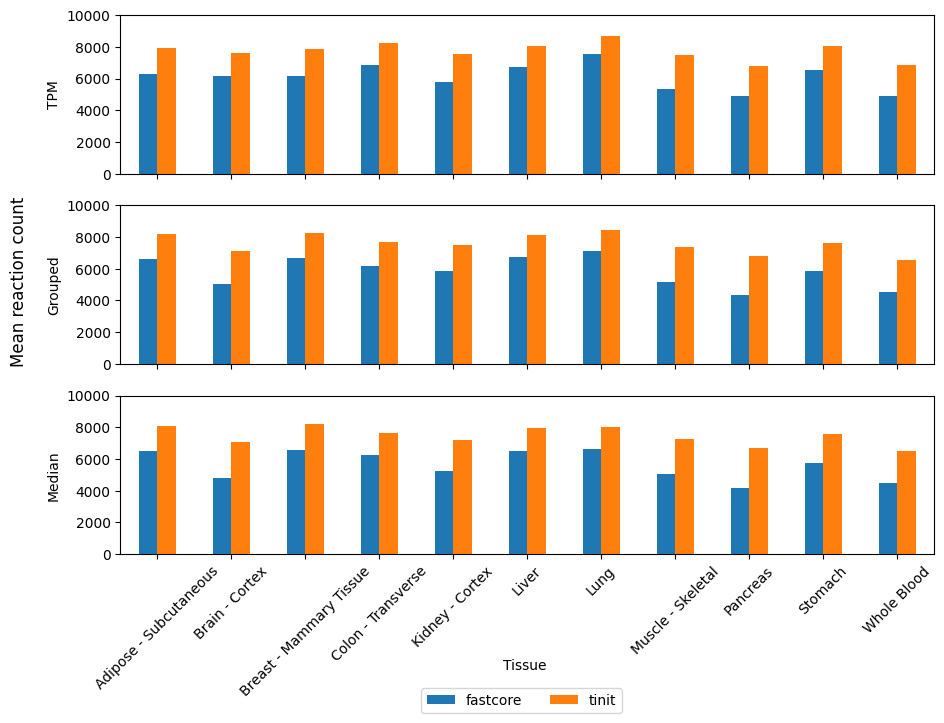

In [40]:
fig, ax = plt.subplots(3,1,figsize=(10.5,7),sharex=True,sharey=True) #

pd.concat((
    pd.concat((grp_ft.sum(axis=1), grp_ft_more.sum(axis=1))),
    pd.concat((grp_tinit.sum(axis=1), grp_tinit_more.sum(axis=1)))
),axis=1,keys=["fastcore","tinit"]).sort_index().groupby(level=0).mean().round(0).plot(kind="bar",ax=ax[1],legend=False)
pd.concat((
    pd.concat((med_ft.sum(axis=1),med_more_ft.sum(axis=1))),
    pd.concat((med_tinit.sum(axis=1),med_more_tinit.sum(axis=1)))
),axis=1,keys=["fastcore","tinit"]).sort_index().plot(kind="bar",ax=ax[2],legend=False)
tm_rc_temp.round(0).plot(kind="bar",ax=ax[0],legend=False)

ax[0].set_ylim(0,10000) #(3000,10000)
ax[2].legend(bbox_to_anchor=(0.625, -0.8),ncol=2) #, markerscale=1.5
plt.xticks(rotation=45)
ax[0].set_ylabel("TPM")
ax[1].set_ylabel("Grouped")
ax[2].set_ylabel("Median")
fig.supylabel("Mean reaction count") #x=0.035
fig.supxlabel("Tissue",fontsize="medium",y=-0.06,x=0.51)
plt.show()

In [41]:
print("ft median:",pd.concat((med_tasks_ft.sum(axis=1),med_more_tasks_ft.sum(axis=1))).mean())
print("tinit median:",pd.concat((med_tasks_tinit.sum(axis=1),med_more_tasks_tinit.sum(axis=1))).mean())
print("ft group:",pd.concat((grp_tasks_ft.sum(axis=1),grp_ft_more_tasks.sum(axis=1))).mean())
print("tinit group:",pd.concat((grp_tasks_tinit.sum(axis=1),grp_tinit_more_tasks.sum(axis=1))).mean())

ft median: 27.0
tinit median: 21.545454545454547
ft group: 27.939393939393938
tinit group: 22.696969696969695


In [42]:
print("Median/Grouped min reaction count:",
min([med_ft.sum(axis=1).min(),med_tinit.sum(axis=1).min(),med_more_ft.sum(axis=1).min(),med_more_tinit.sum(axis=1).min(),
grp_ft.sum(axis=1).min(),grp_tinit.sum(axis=1).min(),
grp_ft_more.sum(axis=1).min(),grp_tinit_more.sum(axis=1).min()]))

print("Median/Grouped max reaction count:",
      max([med_ft.sum(axis=1).max(),med_tinit.sum(axis=1).max(),med_more_ft.sum(axis=1).max(),med_more_tinit.sum(axis=1).max(),
grp_ft.sum(axis=1).max(),grp_tinit.sum(axis=1).max(),
grp_ft_more.sum(axis=1).max(),grp_tinit_more.sum(axis=1).max()]))

Median/Grouped min reaction count: 4101
Median/Grouped max reaction count: 8655


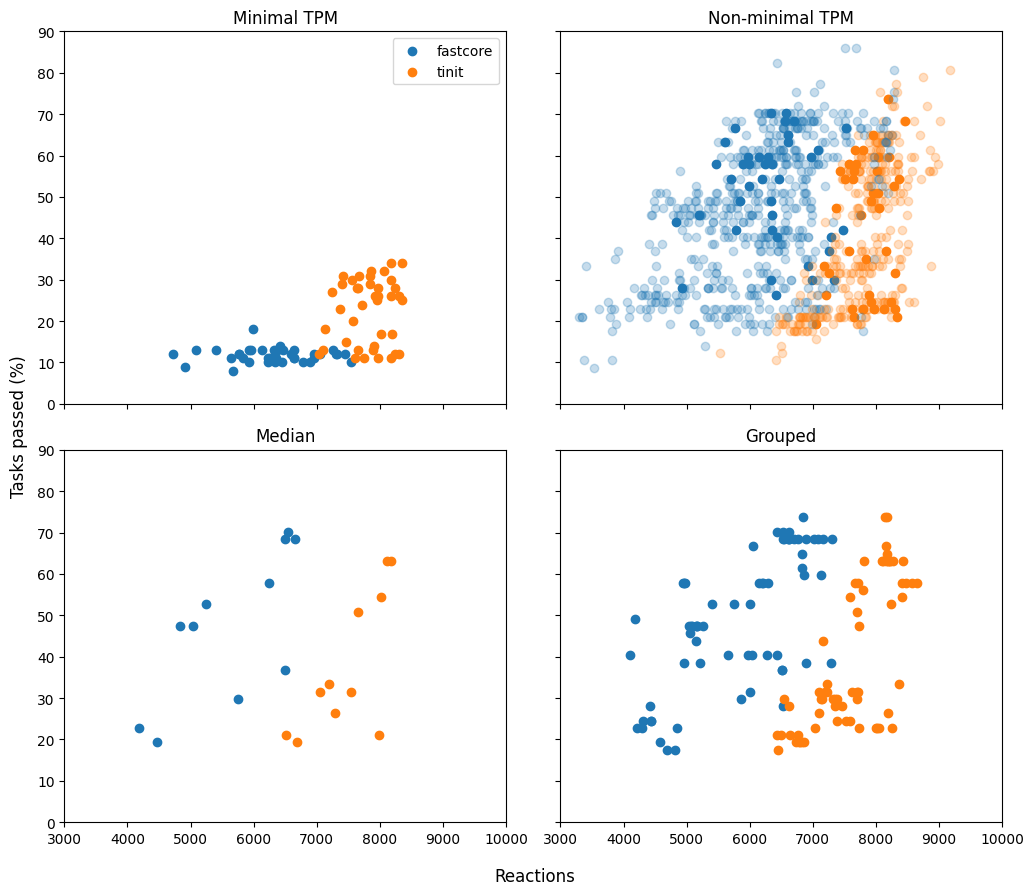

In [43]:
fig, ax = plt.subplots(2,2,figsize=(10.5,9),sharey=True,sharex=True) #figsize=(10,4.5)
fig.supxlabel('Reactions',x=0.52)
fig.supylabel('Tasks passed (%)',y=0.52)
ax[1,0].set_title("Median")
ax[1,1].set_title("Grouped")
ax[0,0].set_title("Minimal TPM")
ax[0,1].set_title("Non-minimal TPM")

ax[0,0].scatter(x=min_csm.loc(axis=0)["fastcore"].sum(axis=1),y=min_csm_tasks.loc(axis=0)["fastcore"].sum(axis=1),
              label="fastcore")
ax[0,0].scatter(x=min_csm.loc(axis=0)["tinit"].sum(axis=1),y=min_csm_tasks.loc(axis=0)["tinit"].sum(axis=1),label="tinit")

ax[0,1].scatter(x=ft_prmat.sum(axis=1).iloc[tissue_ids],y=ft_prmat_tasks.sum(axis=1).iloc[tissue_ids]/57*100,label="fastcore")
ax[0,1].scatter(x=tinit_prmat.sum(axis=1).iloc[tissue_ids],y=tinit_prmat_tasks.sum(axis=1).iloc[tissue_ids]/57*100,label="tinit")
ax[0,1].scatter(x=ft_prmat.sum(axis=1).loc[~ft_prmat.index.isin(ft_prmat.index[tissue_ids])],
              y=ft_prmat_tasks.sum(axis=1).loc[~ft_prmat.index.isin(ft_prmat.index[tissue_ids])]/57*100,label="fastcore",
              alpha=0.25,color="#1f77b4")
ax[0,1].scatter(x=tinit_prmat.sum(axis=1).loc[~ft_prmat.index.isin(ft_prmat.index[tissue_ids])],
              y=tinit_prmat_tasks.sum(axis=1).loc[~ft_prmat.index.isin(ft_prmat.index[tissue_ids])]/57*100,label="tinit",
              alpha=0.25,color="#ff7f0e")
ax[0,1].scatter(x=ft_more.sum(axis=1),
              y=ft_more_tasks.sum(axis=1)/57*100,label="fastcore",alpha=0.25,color="#1f77b4")
ax[0,1].scatter(x=tinit_more.sum(axis=1),y=tinit_more_tasks.sum(axis=1)/57*100,alpha=0.25,label="tinit",color="#ff7f0e")

ax[1,0].scatter(x=med_ft.sum(axis=1),y=med_tasks_ft.sum(axis=1)/57*100,label="fastcore")
ax[1,0].scatter(x=med_tinit.sum(axis=1),y=med_tasks_tinit.sum(axis=1)/57*100,label="tinit")
ax[1,0].scatter(x=med_more_ft.sum(axis=1),y=med_more_tasks_ft.sum(axis=1)/57*100,label="__nolabel__",color="#1f77b4")
ax[1,0].scatter(x=med_more_tinit.sum(axis=1),y=med_more_tasks_tinit.sum(axis=1)/57*100,label="__nolabel__",color="#ff7f0e")

ax[1,1].scatter(x=grp_ft.sum(axis=1),y=grp_tasks_ft.sum(axis=1)/57*100,label="fastcore")
ax[1,1].scatter(x=grp_tinit.sum(axis=1),y=grp_tasks_tinit.sum(axis=1)/57*100,label="tinit")
ax[1,1].scatter(x=grp_ft_more.sum(axis=1),y=grp_ft_more_tasks.sum(axis=1)/57*100,label="__nolabel__",color="#1f77b4")
ax[1,1].scatter(x=grp_tinit_more.sum(axis=1),y=grp_tinit_more_tasks.sum(axis=1)/57*100,label="__nolabel__",color="#ff7f0e")

ax[0,0].set_ylim(0,90)
ax[0,0].set_xlim(3000,10000)

ax[0,0].legend()
plt.tight_layout()
plt.show()

In [44]:
print("Max median VS grouped VS TPM essential passed tasks:")
print(med_tsk_temp.max().max(),grp_tsk_temp.max().max(),
pd.concat((
pd.concat((ft_prmat_tasks.sum(axis=1),ft_more_tasks.sum(axis=1))),
pd.concat((tinit_prmat_tasks.sum(axis=1),tinit_more_tasks.sum(axis=1)))),axis=1,keys=["fastcore","tinit"]).max().max())

Max median VS grouped VS TPM essential passed tasks:
40.0 42.0 49.0


### Gene scores vs Omics data

In [45]:
ft_prmat_novar = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results",
                          "gtl50_gtu90_lt50_ft_4tissue_NOvarthresh_csm_nodrugex.csv"),
                          header=0,index_col=[1]).drop(["Unnamed: 0","Unnamed: 2"], axis=1)

ft_prmat_novar_tsk = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                      "gtl50_gtu90_lt50_ft_4tissue_NOvarthresh_task_nodrugex.json")))
ft_prmat_novar_tsk.index = ft_prmat_novar.index
ft_prmat_novar_tsk.columns = ess_tsks["DESCRIPTION"].to_list()

ft_prmat_1tpm = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results",
                          "gtl50_gtu90_lt50_ft_4tissue_novar_1tpmthresh_csm_nodrugex.csv"),
                          header=0,index_col=[1]).drop(["Unnamed: 0","Unnamed: 2"], axis=1)

ft_prmat_1tpm_tsk = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                      "gtl50_gtu90_lt50_ft_4tissue_novar_1tpmthresh_task_nodrugex.json")))
ft_prmat_1tpm_tsk.index = ft_prmat_1tpm.index
ft_prmat_1tpm_tsk.columns = ess_tsks["DESCRIPTION"].to_list()

In [46]:
print("TPM Omics data models")
print("Average essential tasks:",round(ft_prmat_1tpm_tsk.sum(axis=1).mean(),2))
# print("\tstd essential tasks:",round(ft_prmat_1tpm_tsk.sum(axis=1).std(),2))
print("Average reactions:",round(ft_prmat_1tpm.sum(axis=1).mean(),2))
# print("\tstd reactions:",round(ft_prmat_1tpm.sum(axis=1).std(),2))

TPM Omics data models
Average essential tasks: 40.87
Average reactions: 8866.53


In [47]:
ft_prmat_1tpm_NB = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results",
                          "gtl50_gtu90_lt50_ft_4tissue_novar_1tpmthresh_csm_noblock_nodrugex.csv"),
                          header=0,index_col=0)

In [48]:
print("Average reactions without blocked:",round(ft_prmat_1tpm_NB.sum(axis=1).mean(),2))
print("Average % of blocked reactions:",
      ((ft_prmat_1tpm.sum(axis=1)-ft_prmat_1tpm_NB.sum(axis=1))/ft_prmat_1tpm.sum(axis=1)*100).mean())
print("% of blocked reactions:",
      ((ft_prmat_1tpm.sum(axis=1)-ft_prmat_1tpm_NB.sum(axis=1))/ft_prmat_1tpm.sum(axis=1)*100).describe())

Average reactions without blocked: 4746.23
Average % of blocked reactions: 46.24642233297404
% of blocked reactions: count    212.000000
mean      46.246422
std       11.449006
min        0.000000
25%       45.138936
50%       50.502224
75%       53.797150
max       57.258325
dtype: float64


In [49]:
med_1tpm = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results",
                          "gtl50_gtu90_lt50_fttinit_med_1tpmthresh_csm_nodrugex.csv"),
                          header=0,index_col=[0,1]).drop(["Unnamed: 2"], axis=1) #"Unnamed: 0",

med_1tpm_tsk = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                      "gtl50_gtu90_lt50_fttinit_med_1tpmthresh_task_nodrugex.json")))
med_1tpm_tsk.index = med_1tpm.index
med_1tpm_tsk.columns = ess_tsks["DESCRIPTION"].to_list()

med_1tpm_NB_tinit = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results",
                          "gtl50_gtu90_lt50_init_med_1tpmthresh_csm_noblock_nodrugex.csv"),
                          header=0,index_col=[0]) #.drop(["Unnamed: 2"], axis=1) #"Unnamed: 0",
med_1tpm_NB_ft = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results",
                          "gtl50_gtu90_lt50_ft_med_1tpmthresh_csm_noblock_nodrugex.csv"),
                          header=0,index_col=[0])

In [50]:
print("Median Omics data models")
print("Average essential tasks:")
print("\ttinit:",round(med_1tpm_tsk.loc(axis=0)["tinit"].sum(axis=1).mean(),2))
print("\tfastcore:",round(med_1tpm_tsk.loc(axis=0)["fastcore"].sum(axis=1).mean(),2))
print("Average reactions:")
print("\ttinit:",round(med_1tpm.loc(axis=0)["tinit"].sum(axis=1).mean(),2))
print("\tfastcore:",round(med_1tpm.loc(axis=0)["fastcore"].sum(axis=1).mean(),2))
print("Average reactions without blocked:")
print("\ttinit:",round(med_1tpm_NB_tinit.sum(axis=1).mean(),2))
print("\tfastcore:",round(med_1tpm_NB_ft.sum(axis=1).mean(),2))

Median Omics data models
Average essential tasks:
	tinit: 54.18
	fastcore: 41.82
Average reactions:
	tinit: 10145.73
	fastcore: 8640.91
Average reactions without blocked:
	tinit: 6502.73
	fastcore: 6023.64


In [51]:
print("% blocked reactions:")
print("tinit - average:",round(((med_1tpm.loc(axis=0)["tinit"].sum(axis=1)-med_1tpm_NB_tinit.sum(axis=1))/med_1tpm.loc(
    axis=0)["tinit"].sum(axis=1)*100).mean(),2))
print((med_1tpm.loc(axis=0)["tinit"].sum(axis=1)-med_1tpm_NB_tinit.sum(axis=1))/med_1tpm.loc(axis=0)["tinit"].sum(axis=1)*100,
      end="\n\n")
print("fastcore - average:",round(((med_1tpm.loc(axis=0)["fastcore"].sum(axis=1)-med_1tpm_NB_ft.sum(axis=1))/med_1tpm.loc(
    axis=0)["fastcore"].sum(axis=1)*100).mean(),2))
print((med_1tpm.loc(axis=0)["fastcore"].sum(axis=1)-med_1tpm_NB_ft.sum(axis=1))/med_1tpm.loc(axis=0)["tinit"].sum(axis=1)*100,
      end="\n\n")

% blocked reactions:
tinit - average: 35.93
Adipose - Subcutaneous     20.023850
Breast - Mammary Tissue    31.395349
Kidney - Cortex            36.575649
Liver                      17.462008
Whole Blood                27.809240
Stomach                    35.060193
Lung                       39.040489
Brain - Cortex             43.539492
Muscle - Skeletal          45.411788
Pancreas                   48.529556
Colon - Transverse         50.425490
dtype: float64

fastcore - average: 30.53
Adipose - Subcutaneous      0.000000
Breast - Mammary Tissue     7.055577
Kidney - Cortex            15.129725
Liver                      17.074823
Whole Blood                20.566319
Stomach                    26.899546
Lung                       34.173973
Brain - Cortex             41.382706
Muscle - Skeletal          32.032423
Pancreas                   43.818235
Colon - Transverse         45.814368
dtype: float64



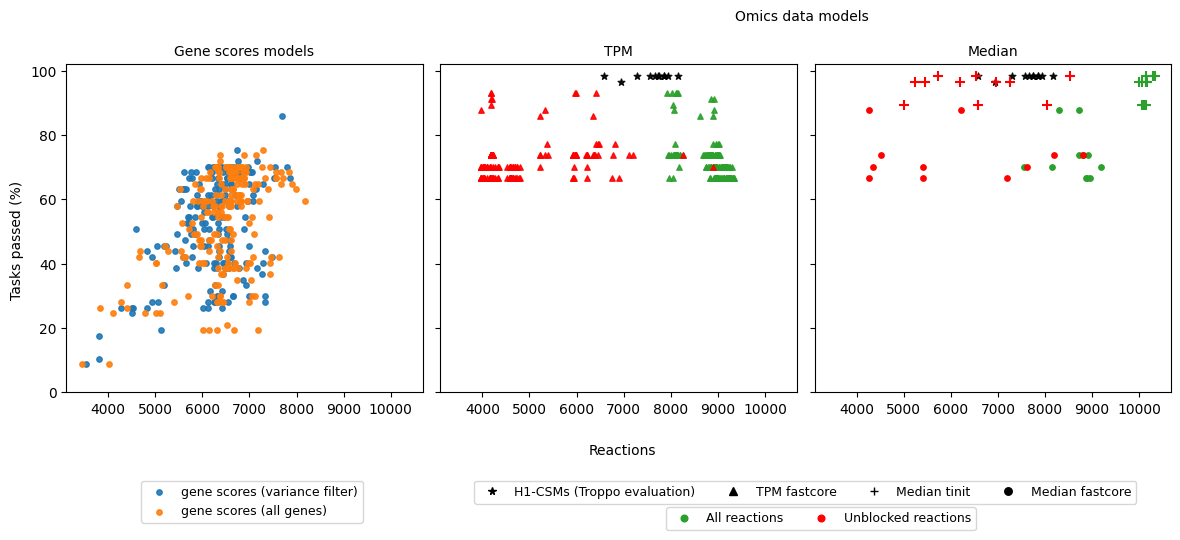

In [52]:
fig, ax = plt.subplots(1,3,figsize=(12,4.35),sharex=True,sharey=True) #figsize=(10,4.5)
fig.supxlabel('Reactions',x=0.53,y=-0.05,fontsize="medium") #,y=-0.2
fig.supylabel('Tasks passed (%)',fontsize="medium",y=0.45) #,y=0.6
ax[0].set_title("Gene scores models",fontsize="medium")
fig.suptitle("Omics data models",fontsize="medium",x=0.68)
ax[1].set_title("TPM",fontsize="medium")
ax[2].set_title("Median",fontsize="medium")
ax[0].set_ylim(0,102)

#'#1f77b4', '#ff7f0e'
ax[0].scatter(x=ft_prmat.sum(axis=1),y=ft_prmat_tasks.sum(axis=1)/57*100,label="gene scores (variance filter)",s=15,alpha=0.9)
ax[0].scatter(x=ft_prmat_novar.sum(axis=1),y=ft_prmat_novar_tsk.sum(axis=1)/57*100,label="gene scores (all genes)",s=15,
              c="#ff7f0e",alpha=0.9)

ax[2].scatter(x=h1_rc.sum(axis=1),y=h1_rc_ess.sum(axis=1)/57*100,label="__nolabel__",
              s=25,c="black",marker="*",alpha=0.9)
ax[1].scatter(x=h1_rc.sum(axis=1),y=h1_rc_ess.sum(axis=1)/57*100,label="__nolabel__",
              s=25,c="black",marker="*",alpha=0.9)

ax[1].scatter(x=ft_prmat_1tpm.sum(axis=1),y=ft_prmat_1tpm_tsk.sum(axis=1)/57*100,label="__nolabel__",
              s=15,c="#2ca02c",marker="^",alpha=0.9) ##2ca02c
ax[1].scatter(x=ft_prmat_1tpm_NB.sum(axis=1),y=ft_prmat_1tpm_tsk.sum(axis=1)/57*100,label="__nolabel__",
              s=15,c="red",marker="^",alpha=0.9)

ax[2].scatter(x=med_1tpm.loc(axis=0)["tinit"].sum(axis=1),
           y=med_1tpm_tsk.sum(axis=1).loc(axis=0)["tinit"]/57*100,label="__nolabel__",s=45,c="#2ca02c",
           marker="+")
ax[2].scatter(x=med_1tpm_NB_tinit.sum(axis=1),
           y=med_1tpm_tsk.sum(axis=1).loc(axis=0)["tinit"]/57*100,label="__nolabel__",s=45,c="red",
           marker="+")

ax[2].scatter(x=med_1tpm.loc(axis=0)["fastcore"].sum(axis=1),
           y=med_1tpm_tsk.sum(axis=1).loc(axis=0)["fastcore"]/57*100,label="__nolabel__",s=15,c="#2ca02c",
           marker="o")
ax[2].scatter(x=med_1tpm_NB_ft.sum(axis=1),
           y=med_1tpm_tsk.sum(axis=1).loc(axis=0)["fastcore"]/57*100,label="__nolabel__",s=15,c="red",
           marker="o")

kwargs4 = {'color': 'black', 'linewidth': 0, 'marker': '*'}
kwargs5 = {'color': 'black', 'linewidth': 0, 'marker': '^'}
kwargs6 = {'color': 'black', 'linewidth': 0, 'marker': '+'}
kwargs3 = {'color': 'black', 'linewidth': 0, 'marker': 'o'}

kwargs7 = {'color': '#2ca02c', 'linewidth': 0, 'marker': 'o'}
kwargs8 = {'color': 'red', 'linewidth': 0, 'marker': 'o'}

ax[1].plot([], [], label='H1-CSMs (Troppo evaluation)', **kwargs4)
ax[1].plot([], [], label='TPM fastcore', **kwargs5)
ax[1].plot([], [], label='Median tinit', **kwargs6)
ax[1].plot([], [], label='Median fastcore', **kwargs3)

ax[2].plot([], [], label='All reactions', **kwargs7)
ax[2].plot([], [], label='Unblocked reactions', **kwargs8)

ax[0].legend(ncol=1,fontsize=9,bbox_to_anchor=(0.85, -0.25)) #,markerscale=0.7,fontsize=9
ax[1].legend(ncol=4,fontsize=9,bbox_to_anchor=(1.97, -0.25),markerscale=0.9) # ,bbox_to_anchor=(0.85, -0.1) 
ax[2].legend(ncol=2,fontsize=9,markerscale=0.8,bbox_to_anchor=(0.47, -0.33))
plt.tight_layout()
fig.subplots_adjust(bottom=0.1,wspace=0.05)
plt.show()

### Full tasks

In [92]:
full_tsks = pd.read_excel(os.path.join(ROOT_FOLDER,"Human-GEM","data","metabolicTasks", 'metabolicTasks_Full.xlsx')
                          ,sheet_name=1)

Full task names

In [93]:
valid_tdf = full_tsks.loc[full_tsks.iloc[:, 0] != '#', :].iloc[:, 1:]
valid_tdf = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),:].reset_index().iloc[:,1:]

from collections import Counter
id_counter = Counter()

real_id = []
for i in valid_tdf['ID'].fillna(-1):
    if i != -1:
        id_counter[i] += 1
        real_id.append(str(i) + str(id_counter[i]))
    else:
        real_id.append(real_id[-1])
valid_tdf['ID'] = real_id
print(valid_tdf.shape)

(256, 17)


HK vs Non-HK and by tissue

In [94]:
full_tsks_info = pd.read_excel(os.path.join(ROOT_FOLDER,"DATA", 'Uhlen2015_SM_S1-S18.xlsx'),
                               sheet_name="S16",index_col=0,header=0)
hk_full_tsks = full_tsks_info.loc[full_tsks_info.iloc[:,1:-1].all(axis=1),"DESCRIPTION"]

C:\Users\liamo\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [95]:
ft_prmat_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                      "gtl50_gtu90_lt50_ft_4tissues_rin6_prmat_full_nodrugex.json")))
ft_prmat_full.index = ft_prmat.index
ft_prmat_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

tinit_prmat_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                         "gtl50_gtu90_lt50_tinit_4tissues_rin6_prmat_full_nodrugex.json")))
tinit_prmat_full.index = tinit_prmat.index
tinit_prmat_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

ft_more_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                      "gtl50_gtu90_lt50_ft53_more_rin6_full_nodrugex.json")))
ft_more_full.index = ft_more.index
ft_more_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

tinit_more_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                      "gtl50_gtu90_lt50_tinit20_more_rin6_full_nodrugex.json")))
tinit_more_full.index = tinit_more.index
tinit_more_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

In [96]:
med_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                        "gtl50_gtu90_lt50_fttinit_mediantpm4_full_nodrugex.json")))
med_full.index = med.index
med_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]
med_full_tinit = med_full.loc[med["Unnamed: 0"]=="tinit",:]
med_full_ft = med_full.loc[med["Unnamed: 0"]=="fastcore",:]

med_more_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                        "gtl50_gtu90_lt50_fttinit_mediantpm7_full_nodrugex.json")))
med_more_full.index = med_more.index
med_more_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]
med_more_full_tinit = med_more_full.loc[med_more["Unnamed: 0"]=="tinit",:]
med_more_full_ft = med_more_full.loc[med_more["Unnamed: 0"]=="fastcore",:]

In [97]:
grp_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                        "gtl50_gtu90_lt50_fttinit_median_by_TSAn4_full_nodrugex.json")))
grp_full.index = grp.index
grp_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]
grp_full_tinit = grp_full.loc[grp["Unnamed: 0"]=="tinit",:]
grp_full_ft = grp_full.loc[grp["Unnamed: 0"]=="fastcore",:]

grp_ft_more_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                        "gtl50_gtu90_lt50_ft_median_by_TSAn7_full_nodrugex.json")))
grp_ft_more_full.index = grp_ft_more.index
grp_ft_more_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

grp_tinit_more_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                        "gtl50_gtu90_lt50_tinit_median_by_TSAn7_full_nodrugex.json")))
grp_tinit_more_full.index = grp_tinit_more.index
grp_tinit_more_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

Robinson et al. full tasks

In [98]:
h1_rc_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results","tINIT_GTEx_11fulltasks.json")))
h1_rc_full.index = h1_rc.index
h1_rc_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

#### Task evaluation: Troppo VS MATLAB comparison

In [99]:
print("Full tasks failed by the Human-GEM model according to Troppo")
valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"].loc[~h1xml_full_trp[2]].to_list()
# h1xml_full_trp[2]

Full tasks failed by the Human-GEM model according to Troppo


['Tryptophan uptake',
 'Aspartate degradation',
 'cis-gondoic acid (complete oxidation)',
 '8,11-Eicosadienoic acid (complete oxidation)',
 'Henicosanoic acid (complete oxidation)',
 'cis-erucic acid (complete oxidation)',
 'Tricosanoic acid (complete oxidation)',
 'Cerotic acid (complete oxidation)',
 'Linolenate (complete oxidation)',
 'omega-3-Arachidonic acid (complete oxidation)',
 'DPA (complete oxidation)',
 '6Z,9Z,12Z,15Z,18Z,21Z-THA (complete oxidation)',
 '13,16,19-docosatrienoic acid (complete oxidation)',
 '10,13,16,19-docosatetraenoic acid (complete oxidation)',
 'Linoleate (complete oxidation)']

In [ ]:
print("Full tasks failed by the template model according to Troppo")
valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"].loc[~template_full[2]].to_list()

In [100]:
h1_rc_full_mat = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","H1_CSMS_11fulltasks_MAT.csv"),header=None).transpose()
h1_rc_full_mat.index = sorted(h1_rc.index)
h1_rc_full_mat.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

In [101]:
h1fullvs = h1_rc_full_mat.astype(bool)==h1_rc_full.sort_index()
print("Troppo VS MATLAB")
print("Tasks with different behaviour in at least onde model:",h1fullvs.loc[:,(~h1fullvs.all())].shape[1],
      "(",round(h1fullvs.loc[:,(~h1fullvs.all())].shape[1]/h1fullvs.shape[1]*100,2),"%)")
# print("Pairwise difference (%):",100-(h1fullvs.sum().sum()/h1fullvs.size*100))
del h1fullvs

Troppo VS MATLAB
Tasks with different behaviour in at least onde model: 95 ( 37.11 %)


In [102]:
print(h1_rc_full_mat.sum(axis=1).sort_values())

breast            209
lung              212
blood             214
adipose tissue    215
colon             215
muscle            215
pancreas          215
stomach           215
brain             216
kidney            216
liver             222
dtype: int64


In [103]:
print("Tasks failed by all H1-CSMS:",h1_rc_full_mat.loc[:,(~h1_rc_full_mat.all() & ~h1_rc_full_mat.any())].shape,end="\n\n")
print("Tasks not passed or failed by all H1-CSMS:",h1_rc_full_mat.loc[:,(~h1_rc_full_mat.all() & h1_rc_full_mat.any())].shape)
print("Tasks not passed or failed by all H1-CSMS & are HK tasks:")
print(h1_rc_full_mat.loc[:,(~h1_rc_full_mat.all() & h1_rc_full_mat.any() &
                      h1_rc_full_mat.columns.isin(hk_full_tsks))].columns.to_list())

Tasks failed by all H1-CSMS: (11, 29)

Tasks not passed or failed by all H1-CSMS: (11, 21)
Tasks not passed or failed by all H1-CSMS & are HK tasks:
['Glycine de novo synthesis (minimal substrates, minimal excretion)', 'Heme de novo synthesis (minimal substrates, physiological excretion)', 'Acetoacetate de novo synthesis']


Prints

In [104]:
tpm_ftemp = pd.concat((
    pd.concat((ft_prmat_full.loc[:,ft_prmat_full.columns.isin(hk_full_tsks)],
               ft_prmat_full.loc[:,~ft_prmat_full.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"]),
    pd.concat((ft_more_full.loc[:,ft_more_full.columns.isin(hk_full_tsks)],
               ft_more_full.loc[:,~ft_more_full.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"])))
tpm_ftemp = pd.concat((tpm_ftemp,
    pd.concat((
    pd.concat((tinit_prmat_full.loc[:,tinit_prmat_full.columns.isin(hk_full_tsks)],
               tinit_prmat_full.loc[:,~tinit_prmat_full.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"]),
    pd.concat((tinit_more_full.loc[:,tinit_more_full.columns.isin(hk_full_tsks)],
               tinit_more_full.loc[:,~tinit_more_full.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"])))
                      ),keys=["ft","tinit"])

print("TPM fastcore")
print("Universally passed:")
print("\tHK:",tpm_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].all().sum())
print("\tOther",tpm_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].all().sum())
print("Universally failed:")
print("\tHK:",(~tpm_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].any()).sum())
print("\tOther",(~tpm_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].any()).sum())   
print("Neither:")
print("\tHK:",(tpm_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].any() & 
              ~tpm_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].all()).sum())
print("\tOther",(tpm_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].any()  & 
              ~tpm_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].all()).sum(),end="\n\n")  

print("TPM tinit")
print("Universally passed:")
print("\tHK:",tpm_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].all().sum())
print("\tOther",tpm_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].all().sum())
print("Universally failed:")
print("\tHK:",(~tpm_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].any()).sum())
print("\tOther",(~tpm_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].any()).sum())   
print("Neither:")
print("\tHK:",(tpm_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].any() & 
              ~tpm_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].all()).sum())
print("\tOther",(tpm_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].any()  & 
              ~tpm_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].all()).sum(),end="\n\n")  

TPM fastcore
Universally passed:
	HK: 28
	Other 12
Universally failed:
	HK: 8
	Other 3
Neither:
	HK: 156
	Other 49

TPM tinit
Universally passed:
	HK: 30
	Other 13
Universally failed:
	HK: 25
	Other 7
Neither:
	HK: 137
	Other 44



In [105]:
grp_ftemp = pd.concat((
    pd.concat((grp_full_ft.loc[:,grp_full_ft.columns.isin(hk_full_tsks)],
               grp_full_ft.loc[:,~grp_full_ft.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"]),
    pd.concat((grp_ft_more_full.loc[:,grp_ft_more_full.columns.isin(hk_full_tsks)],
               grp_ft_more_full.loc[:,~grp_ft_more_full.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"])))
grp_ftemp = pd.concat((grp_ftemp,
    pd.concat((
    pd.concat((grp_full_tinit.loc[:,grp_full_tinit.columns.isin(hk_full_tsks)],
               grp_full_tinit.loc[:,~grp_full_tinit.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"]),
    pd.concat((grp_tinit_more_full.loc[:,grp_tinit_more_full.columns.isin(hk_full_tsks)],
               grp_tinit_more_full.loc[:,~grp_tinit_more_full.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"])))
                      ),keys=["ft","tinit"])

print("Grouped fastcore")
print("Universally passed:")
print("\tHK:",grp_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].all().sum())
print("\tOther",grp_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].all().sum())
print("Universally failed:")
print("\tHK:",(~grp_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].any()).sum())
print("\tOther",(~grp_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].any()).sum())   
print("Neither:")
print("\tHK:",(grp_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].any() & 
              ~grp_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].all()).sum())
print("\tOther",(grp_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].any()  & 
              ~grp_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].all()).sum(),end="\n\n")  

print("Grouped tinit")
print("Universally passed:")
print("\tHK:",grp_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].all().sum())
print("\tOther",grp_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].all().sum())
print("Universally failed:")
print("\tHK:",(~grp_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].any()).sum())
print("\tOther",(~grp_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].any()).sum())   
print("Neither:")
print("\tHK:",(grp_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].any() & 
              ~grp_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].all()).sum())
print("\tOther",(grp_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].any()  & 
              ~grp_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].all()).sum(),end="\n\n") 

Grouped fastcore
Universally passed:
	HK: 33
	Other 12
Universally failed:
	HK: 34
	Other 9
Neither:
	HK: 125
	Other 43

Grouped tinit
Universally passed:
	HK: 35
	Other 13
Universally failed:
	HK: 41
	Other 9
Neither:
	HK: 116
	Other 42



In [106]:
med_ftemp = pd.concat((
    pd.concat((med_full_ft.loc[:,med_full_ft.columns.isin(hk_full_tsks)],
               med_full_ft.loc[:,~med_full_ft.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"]),
    pd.concat((med_more_full_ft.loc[:,med_more_full_ft.columns.isin(hk_full_tsks)],
               med_more_full_ft.loc[:,~med_more_full_ft.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"])))
med_ftemp = pd.concat((med_ftemp,
    pd.concat((
    pd.concat((med_full_tinit.loc[:,med_full_tinit.columns.isin(hk_full_tsks)],
               med_full_tinit.loc[:,~med_full_tinit.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"]),
    pd.concat((med_more_full_tinit.loc[:,med_more_full_tinit.columns.isin(hk_full_tsks)],
               med_more_full_tinit.loc[:,~med_more_full_tinit.columns.isin(hk_full_tsks)]),axis=1,keys=["HK","Other"])))
                      ),keys=["ft","tinit"])

print("Median fastcore")
print("Universally passed:")
print("\tHK:",med_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].all().sum())
print("\tOther",med_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].all().sum())
print("Universally failed:")
print("\tHK:",(~med_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].any()).sum())
print("\tOther",(~med_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].any()).sum())   
print("Neither:")
print("\tHK:",(med_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].any() & 
              ~med_ftemp.loc(axis=0)["ft",:].loc(axis=1)["HK",:].all()).sum())
print("\tOther",(med_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].any()  & 
              ~med_ftemp.loc(axis=0)["ft",:].loc(axis=1)["Other",:].all()).sum(),end="\n\n")  

print("Median tinit")
print("Universally passed:")
print("\tHK:",med_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].all().sum())
print("\tOther",med_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].all().sum())
print("Universally failed:")
print("\tHK:",(~med_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].any()).sum())
print("\tOther",(~med_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].any()).sum())   
print("Neither:")
print("\tHK:",(med_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].any() & 
              ~med_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["HK",:].all()).sum())
print("\tOther",(med_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].any()  & 
              ~med_ftemp.loc(axis=0)["tinit",:].loc(axis=1)["Other",:].all()).sum(),end="\n\n")  

Median fastcore
Universally passed:
	HK: 35
	Other 12
Universally failed:
	HK: 56
	Other 9
Neither:
	HK: 101
	Other 43

Median tinit
Universally passed:
	HK: 36
	Other 14
Universally failed:
	HK: 63
	Other 13
Neither:
	HK: 93
	Other 37



In [107]:
print("Passed by all:")
print("\tHK:",
      (med_ftemp.loc(axis=1)["HK"].all() & grp_ftemp.loc(axis=1)["HK"].all() & tpm_ftemp.loc(axis=1)["HK"].all()).sum())
print("\tOther:",
  (med_ftemp.loc(axis=1)["Other"].all() & grp_ftemp.loc(axis=1)["Other"].all() & tpm_ftemp.loc(axis=1)["Other"].all()).sum())
print("Failed by all:")
print("\tHK:",
      (~med_ftemp.loc(axis=1)["HK"].any() & ~grp_ftemp.loc(axis=1)["HK"].any() & ~tpm_ftemp.loc(axis=1)["HK"].any()).sum())
print("\tOther:",
  (~med_ftemp.loc(axis=1)["Other"].any() & ~grp_ftemp.loc(axis=1)["Other"].any() & ~tpm_ftemp.loc(axis=1)["Other"].any()).sum())

Passed by all:
	HK: 28
	Other: 12
Failed by all:
	HK: 7
	Other: 3


#### All full tasks/models graph

In [108]:
df_list = []
# df_list2 = []
for i,df in enumerate([ft_prmat_full,tinit_prmat_full,ft_more_full,tinit_more_full]):
#     if i <= 1: md = tissue_meta
#     else: md = tissue_meta_allrin
    
    df_list.append(pd.concat((df.loc[:,hk_full_tsks].sum(axis=1),
           df.loc[:,~df.columns.isin(hk_full_tsks)].sum(axis=1)),
          axis=1,keys=["HK","Other"]).groupby(tissue_meta_allrin.loc[df.index,"Tissue"]).mean()) #md
#     if i in [0,2]: df_list2.append(df.loc[:,~df.columns.isin(hk_full_tsks)].sum())
    
full_stack = pd.concat(df_list,axis=0,keys=["fastcore","tinit"]*2)
full_stack = full_stack.sort_index(level=1).round(2)
# full_stack.index.set_names("Algorithm",level=0,inplace=True) doesnt fix loc(axis=0) for algorithms
full_stack.head(2)

,,HK,Other
,Tissue,,
fastcore,Adipose - Subcutaneous,111.34,42.87
tinit,Adipose - Subcutaneous,104.55,44.68


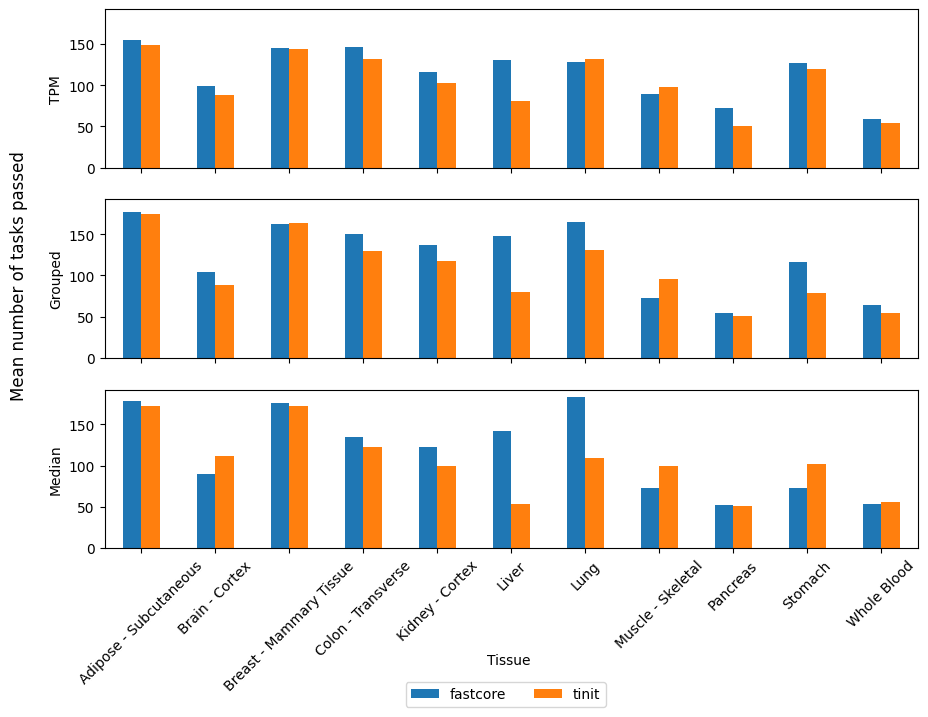

In [109]:
fig,ax = plt.subplots(3,1,figsize=(10.5,7),sharex=True,sharey=True)
pd.concat((tpm_ftemp.loc(axis=0)["ft",:].sum(axis=1)["ft"].groupby(
    tissue_meta_allrin.loc[tpm_ftemp.loc(axis=0)["ft",:].sum(axis=1)["ft"].index,"Tissue"]).mean().round(2).sort_index(),
          tpm_ftemp.loc(axis=0)["tinit",:].sum(axis=1)["tinit"].groupby(
    tissue_meta_allrin.loc[tpm_ftemp.loc(axis=0)["tinit",:].sum(axis=1)["tinit"].index,"Tissue"]).mean().round(2).sort_index()),
         axis=1,keys=["fastcore","tinit"]).plot(kind="bar",ax=ax[0],legend=False)

pd.concat((grp_ftemp.loc(axis=0)["ft",:].sum(axis=1).groupby(level=1).mean().round(2).sort_index(),
          grp_ftemp.loc(axis=0)["tinit",:].sum(axis=1).groupby(level=1).mean().round(2).sort_index()),
         axis=1,keys=["fastcore","tinit"]).plot(kind="bar",ax=ax[1],legend=False)

pd.concat((med_ftemp.loc(axis=0)["ft",:].sum(axis=1)["ft"].round(2).sort_index(),
          med_ftemp.loc(axis=0)["tinit",:].sum(axis=1)["tinit"].round(2).sort_index()),
         axis=1,keys=["fastcore","tinit"]).plot(kind="bar",ax=ax[2],legend=False)

# ax[0].legend(bbox_to_anchor=(1.15,1))
ax[2].legend(bbox_to_anchor=(0.625, -0.8),ncol=2) #, markerscale=1.5
plt.xticks(rotation=45)
ax[0].set_ylabel("TPM")
ax[1].set_ylabel("Grouped")
ax[2].set_ylabel("Median")
fig.supylabel("Mean number of tasks passed",x=0.035)
fig.supxlabel("Tissue",fontsize="medium",y=-0.06,x=0.51) #
# ax[2].set_xlabel("Tissue")
plt.show()

In [64]:
temp = pd.concat((
    pd.concat((tpm_ftemp.loc(axis=0)["ft",:].sum(axis=1)["ft"].groupby(
    tissue_meta_allrin.loc[tpm_ftemp.loc(axis=0)["ft",:].sum(axis=1)["ft"].index,"Tissue"]).mean().round(2).sort_index(),
          tpm_ftemp.loc(axis=0)["tinit",:].sum(axis=1)["tinit"].groupby(
    tissue_meta_allrin.loc[tpm_ftemp.loc(axis=0)["tinit",:].sum(axis=1)["tinit"].index,"Tissue"]).mean().round(2).sort_index()),
         axis=1,keys=["fastcore","tinit"]),
    pd.concat((grp_ftemp.loc(axis=0)["ft",:].sum(axis=1).groupby(level=1).mean().round(2).sort_index(),
          grp_ftemp.loc(axis=0)["tinit",:].sum(axis=1).groupby(level=1).mean().round(2).sort_index()),
         axis=1,keys=["fastcore","tinit"]),
    pd.concat((med_ftemp.loc(axis=0)["ft",:].sum(axis=1)["ft"].round(2).sort_index(),
          med_ftemp.loc(axis=0)["tinit",:].sum(axis=1)["tinit"].round(2).sort_index()),
         axis=1,keys=["fastcore","tinit"])
),axis=1,keys=["TPM","GRP","MED"])

temp.iloc[0,:]

TPM  fastcore    154.21
     tinit       149.23
GRP  fastcore    177.00
     tinit       175.00
MED  fastcore    178.00
     tinit       172.00
Name: Adipose - Subcutaneous, dtype: float64

#### Percentage of models that pass each task by tissue

In [65]:
full_pct_ft = pd.concat((
    ft_prmat_full.astype("int").groupby(tissue_meta.loc[ft_prmat_full.index,"Tissue"]).sum()/53, 
    ft_more_full.astype("int").groupby(tissue_meta_allrin.loc[ft_more_full.index,"Tissue"]).sum()/53
)).rename(index={"Whole Blood": "Blood (Whole)"}).sort_index()

full_pct_tinit = pd.concat((
    tinit_prmat_full.astype("int").groupby(tissue_meta.loc[tinit_prmat_full.index,"Tissue"]).sum()/53,
    tinit_more_full.astype("int").groupby(tissue_meta_allrin.loc[tinit_more_full.index,"Tissue"]).sum()/20
)).rename(index={"Whole Blood": "Blood (Whole)"}).sort_index()

full_pct_ft.iloc[:3,:5]

DESCRIPTION,Aerobic rephosphorylation of ATP from glucose,Aerobic rephosphorylation of ATP from a fatty acid,Aerobic rephosphorylation of GTP,Aerobic rephosphorylation of CTP,Aerobic rephosphorylation of UTP
Tissue,,,,,
Adipose - Subcutaneous,1.000000,0.000000,0.0,0.0,0.0
Blood (Whole),0.320755,0.000000,0.0,0.0,0.0
Brain - Cortex,0.773585,0.018868,0.0,0.0,0.0


In [66]:
print("H1-CSMs - MATLAB")
print("Universally failed:")
print("\tHK:",
      h1_rc_full_mat.loc[:,(~h1_rc_full_mat.any() & h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full_mat.loc[:,(~h1_rc_full_mat.any() & h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      h1_rc_full_mat.loc[:,(~h1_rc_full_mat.any() & ~h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full_mat.loc[:,(~h1_rc_full_mat.any() & ~h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
print("Universally passed:")
print("\tHK:",
      h1_rc_full_mat.loc[:,(h1_rc_full_mat.all() & h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full_mat.loc[:,(h1_rc_full_mat.all() & h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      h1_rc_full_mat.loc[:,(h1_rc_full_mat.all() & ~h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full_mat.loc[:,(h1_rc_full_mat.all() & ~h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
print("Neither:")
print("\tHK:",
      h1_rc_full_mat.loc[:,(~h1_rc_full_mat.all() & h1_rc_full_mat.any() & h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full_mat.loc[:,(~h1_rc_full_mat.all() & h1_rc_full_mat.any() & h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      h1_rc_full_mat.loc[:,(~h1_rc_full_mat.all() & h1_rc_full_mat.any() & ~h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full_mat.loc[:,(~h1_rc_full_mat.all() & h1_rc_full_mat.any() & ~h1_rc_full_mat.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 

H1-CSMs - MATLAB
Universally failed:
	HK: 0 ( 0.0 % )
	Other: 29 ( 45.3125 % )
Universally passed:
	HK: 189 ( 98.4375 % )
	Other: 17 ( 26.5625 % )
Neither:
	HK: 3 ( 1.5625 % )
	Other: 18 ( 28.125 % )


In [67]:
print("H1-CSMs - Troppo")
print("Universally failed:")
print("\tHK:",
      h1_rc_full.loc[:,(~h1_rc_full.any() & h1_rc_full.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full.loc[:,(~h1_rc_full.any() & h1_rc_full.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      h1_rc_full.loc[:,(~h1_rc_full.any() & ~h1_rc_full.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full.loc[:,(~h1_rc_full.any() & ~h1_rc_full.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
print("Universally passed:")
print("\tHK:",
      h1_rc_full.loc[:,(h1_rc_full.all() & h1_rc_full.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full.loc[:,(h1_rc_full.all() & h1_rc_full.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      h1_rc_full.loc[:,(h1_rc_full.all() & ~h1_rc_full.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full.loc[:,(h1_rc_full.all() & ~h1_rc_full.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
print("Neither:")
print("\tHK:",
      h1_rc_full.loc[:,(~h1_rc_full.all() & h1_rc_full.any() & h1_rc_full.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full.loc[:,(~h1_rc_full.all() & h1_rc_full.any() & h1_rc_full.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      h1_rc_full.loc[:,(~h1_rc_full.all() & h1_rc_full.any() & ~h1_rc_full.columns.isin(hk_full_tsks))].shape[1],"(",
     h1_rc_full.loc[:,(~h1_rc_full.all() & h1_rc_full.any() & ~h1_rc_full.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 

H1-CSMs - Troppo
Universally failed:
	HK: 25 ( 13.020833333333334 % )
	Other: 7 ( 10.9375 % )
Universally passed:
	HK: 149 ( 77.60416666666666 % )
	Other: 55 ( 85.9375 % )
Neither:
	HK: 18 ( 9.375 % )
	Other: 2 ( 3.125 % )


In [68]:
h1_rc_full_plt = h1_rc_full_mat.loc[:,(~h1_rc_full_mat.all() & h1_rc_full_mat.any())] #h1_rc_full

print("HK not failed or passed by all H1-CSMS:",
      h1_rc_full_plt.loc[:,h1_rc_full_plt.columns.isin(hk_full_tsks)].columns.to_list())
print("Tasks passed by only 1 H1-CSM:",h1_rc_full_plt.loc[:,h1_rc_full_plt.sum()==1].shape[1])
h1_rc_full_plt.loc[:,h1_rc_full_plt.sum()==1].loc[h1_rc_full_plt.loc[:,h1_rc_full_plt.sum()==1].any(axis=1),:]

HK not failed or passed by all H1-CSMS: ['Glycine de novo synthesis (minimal substrates, minimal excretion)', 'Heme de novo synthesis (minimal substrates, physiological excretion)', 'Acetoacetate de novo synthesis']
Tasks passed by only 1 H1-CSM: 10


DESCRIPTION,Gluconeogenesis from Alanine,"Arginine de novo synthesis (minimal substrates, minimal excretion)","beta-Alanine de novo synthesis (minimal substrates, minimal excretion)",Ornithine degradation,Urea from alanine,Urea from glutamine,"Creatine de novo synthesis (minimal substrates, physiological excretion)","Taurocholate de novo synthesis and excretion (minimal substrates, physiological excretion)","Bilirubin conjugation (minimal substrates, physiological excretion)",NH3 import and degradation
adipose tissue,0,0,0,0,0,0,0,0,1,0
blood,0,0,1,0,0,0,0,0,0,0
liver,1,1,0,1,1,1,1,1,0,1


Full task heatmaps

Tasks not passed or failed by tINIT median / TPM models / H1-CSMs (all tissues)


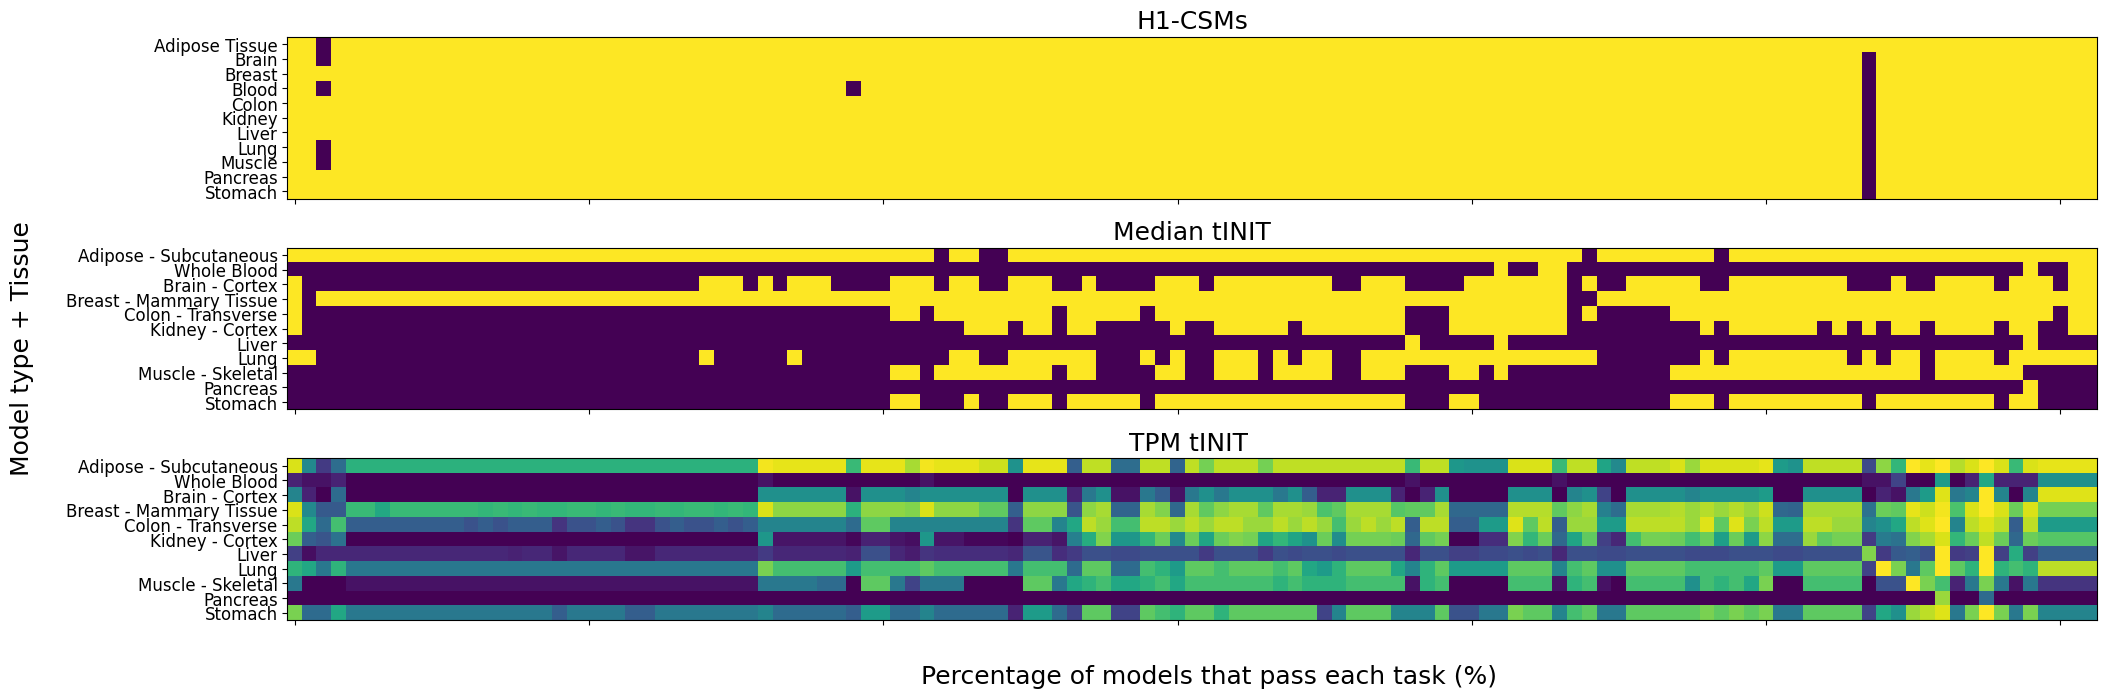

In [69]:
print("Tasks not passed or failed by tINIT median / TPM models / H1-CSMs (all tissues)")
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(3,1,figsize=(21,10),sharex=True)
full_med_pltf = med_ftemp.loc(axis=0)["tinit"].astype("int").droplevel(0,axis=1).rename(
    index={"Whole Blood": "Blood (Whole)"}).sort_index()

mask = (~(full_med_pltf.all() & h1_rc_full.all() & full_pct_ft.round(0).astype(
    "int").all()) & (full_med_pltf.any() & h1_rc_full.any() & full_pct_ft.round(0).astype(
    "int").any()))
im = ax[1].imshow(full_med_pltf.loc[:,mask]*100)
im2 = ax[0].imshow(h1_rc_full.astype("int").loc[:,mask]) #.astype(bool)
im3 = ax[2].imshow(full_pct_tinit.loc[:,mask])

ax[2].set_yticks(np.arange(full_pct_tinit.shape[0]))
ax[2].set_yticklabels([x.title() if x != "Blood (Whole)" else "Whole Blood" for x in full_pct_tinit.index],fontsize=12)
ax[1].set_yticks(np.arange(full_med_pltf.shape[0]))
ax[1].set_yticklabels([x.title() if x != "Blood (Whole)" else "Whole Blood" for x in full_med_pltf.index],fontsize=12)
ax[0].set_yticks(np.arange(h1_rc_full_mat.shape[0]))
ax[0].set_yticklabels([x.title() for x in h1_rc_full.index],fontsize=12)

ax[0].set_xticklabels([])
# ax[2].set_xticks(np.arange(h1_rc_full_mat.loc[:,mask].shape[1])) #labels as HK or Other
# ax[2].set_xticklabels(med_ftemp.loc(axis=1)[:,mask].columns.get_level_values(0).to_list())
# plt.setp(ax[2].get_xticklabels(), rotation=90)

ax[2].set_title("TPM tINIT ",fontsize=18)
ax[1].set_title("Median tINIT",fontsize=18)
ax[0].set_title("H1-CSMs",fontsize=18)
fig.supylabel("Model type + Tissue", fontsize=18,x=-0.001)
fig.supxlabel("Percentage of models that pass each task (%)", fontsize=18,y=0.16,x=0.57)

plt.tight_layout(h_pad=-18) #w_pad=8
plt.show()

Full tasks: Gene scores + variance filter vs gene scores (all genes) vs Omics data (1TPM threshold) models

In [70]:
ft_prmat_novar_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                       "gtl50_gtu90_lt50_ft_4tissue_NOvarthresh_full_nodrugex.json")))
ft_prmat_novar_full.index = ft_prmat_novar.index
ft_prmat_novar_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]


ft_prmat_1tpm_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                       "gtl50_gtu90_lt50_ft_4tissue_novar_1tpmthresh_full_nodrugex.json")))
ft_prmat_1tpm_full.index = ft_prmat_1tpm.index
ft_prmat_1tpm_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

In [71]:
ftprmat_pct = (ft_prmat_full.astype("int").groupby(
    tissue_meta.loc[ft_prmat_full.index,"Tissue"]).sum()/53).sort_index()

ftprmat_novar_pct = (ft_prmat_novar_full.astype("int").groupby(
    tissue_meta.loc[ft_prmat_full.index,"Tissue"]).sum()/53).sort_index()

ftprmat_1tpm_pct = (ft_prmat_1tpm_full.astype("int").groupby(
    tissue_meta.loc[ft_prmat_full.index,"Tissue"]).sum()/53).sort_index()

Tasks not passed or failed by the 3 TPM model types / H1-CSMs (of the 4 tissues)


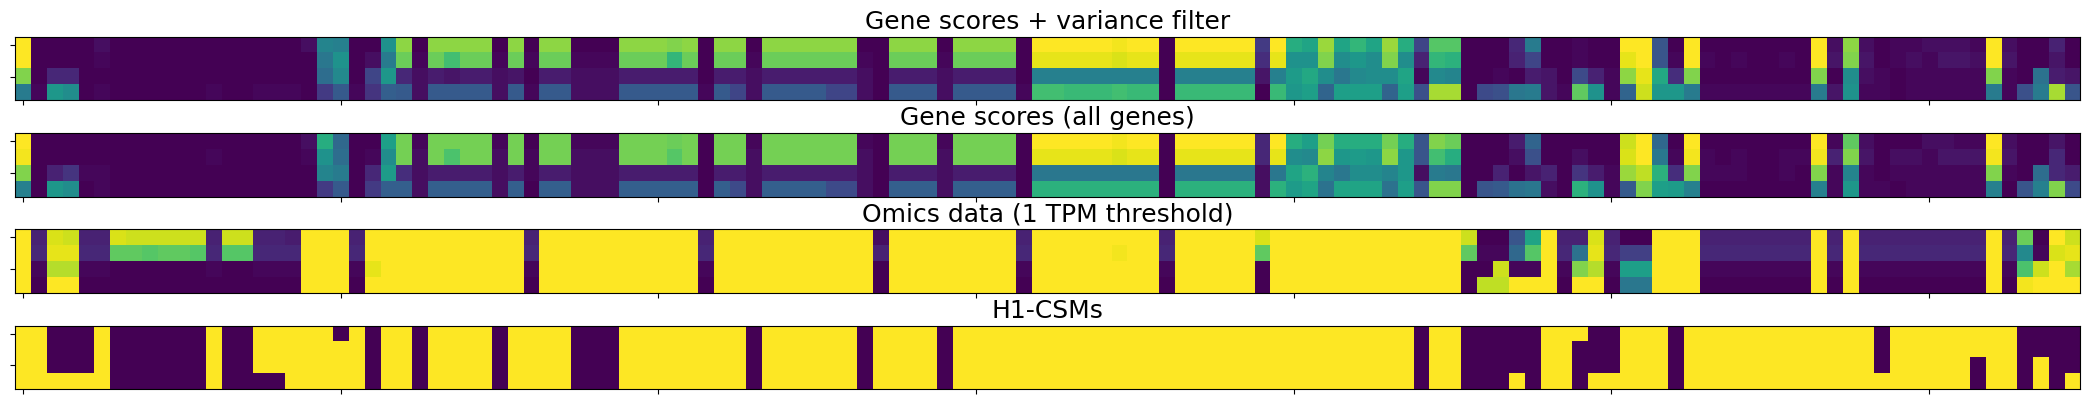

In [72]:
print("Tasks not passed or failed by the 3 TPM model types / H1-CSMs (of the 4 tissues)")
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(4,1,figsize=(21,9),sharex=True,sharey=True)
# mask = ~((ftprmat_pct==1).all() & (ftprmat_novar_pct==1).all() & (ftprmat_1tpm_pct==1).all()  & (h1_rc_full_mat.loc[
#     ["adipose tissue","breast","kidney","liver"],:]==1).all()) & ~(
#     (ftprmat_pct==0).all() & (ftprmat_novar_pct==0).all() & (ftprmat_1tpm_pct==0).all() & (h1_rc_full_mat.loc[
#     ["adipose tissue","breast","kidney","liver"],:]==0).all()) 

mask = ( ~((ftprmat_pct.round(0)==1).all() & (ftprmat_novar_pct.round(0)==1).all() & (ftprmat_1tpm_pct.round(0)==1).all() & (
    h1_rc_full.loc[["adipose tissue","breast","kidney","liver"],:]==1).all()) & ~(
    (ftprmat_pct.round(0)==0).all() & (ftprmat_novar_pct.round(0)==0).all() & (ftprmat_1tpm_pct.round(0)==0).all() & (
        h1_rc_full.astype("int").loc[["adipose tissue","breast","kidney","liver"],:]==0).all()) )

im = ax[0].imshow(ftprmat_pct.loc[:,mask]*100)
im2 = ax[1].imshow(ftprmat_novar_pct.loc[:,mask]*100) 
im3 = ax[2].imshow(ftprmat_1tpm_pct.loc[:,mask]*100)
im4 = ax[3].imshow(h1_rc_full.astype("int").loc[["adipose tissue","breast","kidney","liver"],mask]*100)

# ax[2].set_yticks(np.arange(ftprmat_pct.shape[0]))
# ax[2].set_yticklabels([x.title() for x in ftprmat_pct.index],fontsize=7)
# ax[1].set_yticks(np.arange(ftprmat_pct.shape[0]))
# ax[1].set_yticklabels(ftprmat_pct.index,fontsize=7)
# ax[0].set_yticks(np.arange(ftprmat_pct.shape[0]))
# ax[0].set_yticklabels([x.title() for x in ftprmat_pct.index],fontsize=7)
# ax[3].set_yticks(np.arange(ftprmat_pct.shape[0]))
# ax[3].set_yticklabels([x.title() for x in ["adipose tissue","breast","kidney","liver"]],fontsize=7)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[0].set_title("Gene scores + variance filter",fontsize=18)
ax[1].set_title("Gene scores (all genes)",fontsize=18)
ax[2].set_title("Omics data (1 TPM threshold)",fontsize=18) #"small"
ax[3].set_title("H1-CSMs",fontsize=18)
plt.tight_layout(h_pad=-30) #w_pad=8
plt.show()

In [73]:
print("Gene scores 4-tissue TPM models (all genes)")
print("Universally failed:")
print("\tHK:",
      ft_prmat_novar_full.loc[:,(~ft_prmat_novar_full.any() & ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1],"(",
     round(ft_prmat_novar_full.loc[:,(~ft_prmat_novar_full.any() & ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1]/192*100,4)
      ,"% )") 
print("\tOther:",
      ft_prmat_novar_full.loc[:,(~ft_prmat_novar_full.any() & ~ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1],"(",
     ft_prmat_novar_full.loc[:,(~ft_prmat_novar_full.any() & ~ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
print("Universally passed:")
print("\tHK:",
      ft_prmat_novar_full.loc[:,(ft_prmat_novar_full.all() & ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1],"(",
     round(ft_prmat_novar_full.loc[:,(ft_prmat_novar_full.all() & ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1]/192*100,4),
           "% )") 
print("\tOther:",
      ft_prmat_novar_full.loc[:,(ft_prmat_novar_full.all() & ~ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1],"(",
     ft_prmat_novar_full.loc[:,(ft_prmat_novar_full.all() & ~ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
print("Neither:")
print("\tHK:",
      ft_prmat_novar_full.loc[:,(~ft_prmat_novar_full.all() & ft_prmat_novar_full.any() & ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1],"(",
     ft_prmat_novar_full.loc[:,(~ft_prmat_novar_full.all() & ft_prmat_novar_full.any() & ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      ft_prmat_novar_full.loc[:,(~ft_prmat_novar_full.all() & ft_prmat_novar_full.any() & ~ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1],"(",
     ft_prmat_novar_full.loc[:,(~ft_prmat_novar_full.all() & ft_prmat_novar_full.any() & ~ft_prmat_novar_full.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 

Gene scores 4-tissue TPM models (all genes)
Universally failed:
	HK: 21 ( 10.9375 % )
	Other: 6 ( 9.375 % )
Universally passed:
	HK: 28 ( 14.5833 % )
	Other: 12 ( 18.75 % )
Neither:
	HK: 143 ( 74.47916666666666 % )
	Other: 46 ( 71.875 % )


In [74]:
print("Omics data 4-tissue models (1 TPM threshold)")
print("Universally failed:")
print("\tHK:",
      ftprmat_1tpm_pct.loc[:,(~ftprmat_1tpm_pct.any() & ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1],"(",
     round(ftprmat_1tpm_pct.loc[:,(~ftprmat_1tpm_pct.any() & ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1]/192*100,4)
      ,"% )") 
print("\tOther:",
      ftprmat_1tpm_pct.loc[:,(~ftprmat_1tpm_pct.any() & ~ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1],"(",
     ftprmat_1tpm_pct.loc[:,(~ftprmat_1tpm_pct.any() & ~ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
print("Universally passed:")
print("\tHK:",
      ftprmat_1tpm_pct.loc[:,(ftprmat_1tpm_pct.all() & ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1],"(",
     round(ftprmat_1tpm_pct.loc[:,(ftprmat_1tpm_pct.all() & ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1]/192*100,4),
           "% )") 
print("\tOther:",
      ftprmat_1tpm_pct.loc[:,(ftprmat_1tpm_pct.all() & ~ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1],"(",
     ftprmat_1tpm_pct.loc[:,(ftprmat_1tpm_pct.all() & ~ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
print("Neither:")
print("\tHK:",
      ftprmat_1tpm_pct.loc[:,(~ftprmat_1tpm_pct.all() & ftprmat_1tpm_pct.any() & ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1],"(",
     ftprmat_1tpm_pct.loc[:,(~ftprmat_1tpm_pct.all() & ftprmat_1tpm_pct.any() & ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      ftprmat_1tpm_pct.loc[:,(~ftprmat_1tpm_pct.all() & ftprmat_1tpm_pct.any() & ~ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1],"(",
     ftprmat_1tpm_pct.loc[:,(~ftprmat_1tpm_pct.all() & ftprmat_1tpm_pct.any() & ~ftprmat_1tpm_pct.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 

Omics data 4-tissue models (1 TPM threshold)
Universally failed:
	HK: 2 ( 1.0417 % )
	Other: 3 ( 4.6875 % )
Universally passed:
	HK: 143 ( 74.4792 % )
	Other: 58 ( 90.625 % )
Neither:
	HK: 47 ( 24.479166666666664 % )
	Other: 3 ( 4.6875 % )


### Statistics

In [75]:
rct_temp = pd.concat((
    pd.concat((ft_prmat.sum(axis=1),ft_more.sum(axis=1))),
    pd.concat((tinit_prmat.sum(axis=1),tinit_more.sum(axis=1)))
),axis=1,keys=["fastcore","tinit"])
rct_temp = rct_temp.dropna() #ft without matchint tinit
rct_temp["diff"] = rct_temp["fastcore"]-rct_temp["tinit"]

tsk_temp = pd.concat((
    pd.concat((ft_prmat_tasks.sum(axis=1),ft_more_tasks.sum(axis=1))),
    pd.concat((tinit_prmat_tasks.sum(axis=1),tinit_more_tasks.sum(axis=1)))
),axis=1,keys=["fastcore","tinit"])
tsk_temp = tsk_temp.dropna() 
tsk_temp["diff"] = tsk_temp["fastcore"]-tsk_temp["tinit"]

# print(tsk_temp.isna().sum())
print(tsk_temp.shape)

(352, 3)


In [76]:
ft_prmat_tasks.loc[min_csm_tasks.sum(axis=1).loc["tinit",:].index,:].sum(axis=1)
min_vs_prot = pd.concat((
    pd.concat((ft_prmat_tasks.loc[min_csm_tasks.sum(axis=1).loc["tinit",:].index,:].sum(axis=1),
              tinit_prmat_tasks.loc[min_csm_tasks.sum(axis=1).loc["tinit",:].index,:].sum(axis=1)),
              axis=1,keys=["fastcore","tinit"]),
    pd.concat((min_csm_tasks.sum(axis=1).loc["fastcore",:],
              min_csm_tasks.sum(axis=1).loc["tinit",:]),axis=1,keys=["fastcore","tinit"])
),axis=1,keys=["PRMAT","MIN"])

min_vs_prot["DIFF-FT"] = min_vs_prot.loc(axis=1)["PRMAT","fastcore"]-min_vs_prot.loc(axis=1)["MIN","fastcore"]
min_vs_prot["DIFF-tINIT"] = min_vs_prot.loc(axis=1)["PRMAT","tinit"]-min_vs_prot.loc(axis=1)["MIN","tinit"]

#### Shapiro-Wilk normality tests

In [77]:
#not normal
print("All non-minimal models - Tasks")
print("TPM")
print(stats.shapiro(pd.concat((ft_prmat_tasks.sum(axis=1),ft_more_tasks.sum(axis=1)))))
print(stats.shapiro(pd.concat((tinit_prmat_tasks.sum(axis=1),tinit_more_tasks.sum(axis=1)))),end="\n\n")
# print(stats.shapiro(tsk_temp.loc[mask,"fastcore"]))
# print(stats.shapiro(tsk_temp.loc[mask,"tinit"]),end="\n\n")
print("Median")
print(stats.shapiro(med_tsk_temp["fastcore"]))
print(stats.shapiro(med_tsk_temp["tinit"]),end="\n\n")
print("Grouped")
print(stats.shapiro(grp_tsk_temp["fastcore"])) 
print(stats.shapiro(grp_tsk_temp["tinit"])) 

All non-minimal models - Tasks
TPM
ShapiroResult(statistic=0.9625983834266663, pvalue=5.086285212452246e-11)
ShapiroResult(statistic=0.9311736822128296, pvalue=1.1331919777535227e-11)

Median
ShapiroResult(statistic=0.9254529476165771, pvalue=0.3667016625404358)
ShapiroResult(statistic=0.8621203899383545, pvalue=0.06134292483329773)

Grouped
ShapiroResult(statistic=0.9295547008514404, pvalue=0.0010485323145985603)
ShapiroResult(statistic=0.8549323081970215, pvalue=1.7275261825488997e-06)


In [78]:
print("All non-minimal models - Reactions")
print("TPM")
print(stats.shapiro(pd.concat((ft_prmat.sum(axis=1),ft_more.sum(axis=1)))))
print(stats.shapiro(pd.concat((tinit_prmat.sum(axis=1),tinit_more.sum(axis=1)))),end="\n\n")
print("MED")
print(stats.shapiro(pd.concat((med_ft.sum(axis=1),med_more_ft.sum(axis=1)))))
print(stats.shapiro(pd.concat((med_tinit.sum(axis=1),med_more_tinit.sum(axis=1)))),end="\n\n")
print("GRP")
print(stats.shapiro(pd.concat((grp_ft.sum(axis=1),grp_ft_more.sum(axis=1)))))
print(stats.shapiro(pd.concat((grp_tinit.sum(axis=1),grp_tinit_more.sum(axis=1)))))

All non-minimal models - Reactions
TPM
ShapiroResult(statistic=0.9820675253868103, pvalue=1.3986762041895417e-06)
ShapiroResult(statistic=0.9720308780670166, pvalue=2.58406203101913e-06)

MED
ShapiroResult(statistic=0.8891096115112305, pvalue=0.13554945588111877)
ShapiroResult(statistic=0.9320682287216187, pvalue=0.43215319514274597)

GRP
ShapiroResult(statistic=0.931933581829071, pvalue=0.0013424800708889961)
ShapiroResult(statistic=0.9512609243392944, pvalue=0.011369707994163036)


In [79]:
print("Minimal models")
print(stats.shapiro(min_vs_prot.loc(axis=1)["MIN","fastcore"]))
print(stats.shapiro(min_vs_prot.loc(axis=1)["MIN","tinit"]))

Minimal models
ShapiroResult(statistic=0.8901830315589905, pvalue=0.001002658624202013)
ShapiroResult(statistic=0.884900689125061, pvalue=0.0007155341445468366)


In [80]:
print("fastcore TPM: all gene scores / omics 1TPM models - Reactions")
print(stats.shapiro(ft_prmat_novar.sum(axis=1)))
print(stats.shapiro(ft_prmat_1tpm.sum(axis=1)))

fastcore TPM: all gene scores / omics 1TPM models - Reactions
ShapiroResult(statistic=0.9268515110015869, pvalue=8.892704350671465e-09)
ShapiroResult(statistic=0.8228232860565186, pvalue=8.354123328443291e-15)


Full task normality

In [81]:
print("Full tasks")
print("TPM")
print(stats.shapiro(tpm_ftemp.sum(axis=1).loc(axis=0)["ft",:]))
print(stats.shapiro(tpm_ftemp.sum(axis=1).loc(axis=0)["tinit",:]),end="\n\n")
print("Grouped")
print(stats.shapiro(grp_ftemp.sum(axis=1).loc(axis=0)["ft",:]))
print(stats.shapiro(grp_ftemp.sum(axis=1).loc(axis=0)["tinit",:]),end="\n\n")
print("Median")
print(stats.shapiro(med_ftemp.sum(axis=1).loc(axis=0)["ft",:]))
print(stats.shapiro(med_ftemp.sum(axis=1).loc(axis=0)["tinit",:]),end="\n\n")
print("H1-CSMs")
print(stats.shapiro(h1_rc_full.sum(axis=1)))

Full tasks
TPM
ShapiroResult(statistic=0.9335372447967529, pvalue=1.9847426145343326e-15)
ShapiroResult(statistic=0.903218150138855, pvalue=3.3401778657413464e-14)

Grouped
ShapiroResult(statistic=0.912410318851471, pvalue=0.0001939129870152101)
ShapiroResult(statistic=0.8902647495269775, pvalue=2.70968066615751e-05)

Median
ShapiroResult(statistic=0.8978413939476013, pvalue=0.17393410205841064)
ShapiroResult(statistic=0.8934370875358582, pvalue=0.15346771478652954)

H1-CSMs
ShapiroResult(statistic=0.8347669839859009, pvalue=0.026965152472257614)


#### Full task eval: Troppo VS RAVEN

In [82]:
print(stats.shapiro(h1_rc_full_mat.sum(axis=1)))
print(stats.shapiro(h1_rc_full.sum(axis=1)),end="\n\n")

print(stats.mannwhitneyu(h1_rc_full_mat.sum(axis=1),h1_rc_full.sort_index().sum(axis=1),alternative='greater'))

ShapiroResult(statistic=0.8467079997062683, pvalue=0.03865541145205498)
ShapiroResult(statistic=0.8347669839859009, pvalue=0.026965152472257614)

MannwhitneyuResult(statistic=95.5, pvalue=0.010644934961457506)


#### Essential tasks/Reaction count: 2 Independent variables: data type & algorithm -> Kruskal

In [83]:
print("Essential tasks")
print(stats.kruskal(pd.concat((ft_prmat_tasks.sum(axis=1),ft_more_tasks.sum(axis=1))), #TPM
                    pd.concat((tinit_prmat_tasks.sum(axis=1),tinit_more_tasks.sum(axis=1))),
                    med_tsk_temp["fastcore"],med_tsk_temp["tinit"], #MED
                    grp_tsk_temp["fastcore"],grp_tsk_temp["tinit"] #GRP
))

Essential tasks
KruskalResult(statistic=34.482711603810614, pvalue=1.908115908113255e-06)


In [84]:
#replaced p_adjust = 'bonferroni'
res = sp.posthoc_dunn([pd.concat((ft_prmat_tasks.sum(axis=1),ft_more_tasks.sum(axis=1))),
                    pd.concat((tinit_prmat_tasks.sum(axis=1),tinit_more_tasks.sum(axis=1))),
                    med_tsk_temp["fastcore"],med_tsk_temp["tinit"], 
                    grp_tsk_temp["fastcore"],grp_tsk_temp["tinit"]], p_adjust = 'fdr_bh').rename(
    index={1:"FT TPM",2:"tINIT TPM",3:"FT MED",4:"tINIT MED",5:"FT GRP",6:"tINIT GRP"},
    columns={1:"FT TPM",2:"tINIT TPM",3:"FT MED",4:"tINIT MED",5:"FT GRP",6:"tINIT GRP"}) #loc[:-1,:]

res

,FT TPM,tINIT TPM,FT MED,tINIT MED,FT GRP,tINIT GRP
FT TPM,1.000000,0.000022,0.837078,0.261823,0.308638,0.017280
tINIT TPM,0.000022,1.000000,0.308638,0.792523,0.001955,0.807027
FT MED,0.837078,0.308638,1.000000,0.308638,0.807027,0.308638
tINIT MED,0.261823,0.792523,0.308638,1.000000,0.129325,0.807027
FT GRP,0.308638,0.001955,0.807027,0.129325,1.000000,0.011014
tINIT GRP,0.017280,0.807027,0.308638,0.807027,0.011014,1.000000


In [85]:
# res.to_clipboard()

In [86]:
print("Significantly different?")
(res < 0.05)

Significantly different?


,FT TPM,tINIT TPM,FT MED,tINIT MED,FT GRP,tINIT GRP
FT TPM,False,True,False,False,False,True
tINIT TPM,True,False,False,False,True,False
FT MED,False,False,False,False,False,False
tINIT MED,False,False,False,False,False,False
FT GRP,False,True,False,False,False,True
tINIT GRP,True,False,False,False,True,False


In [87]:
print("Reactions")
print(stats.kruskal(pd.concat((ft_prmat.sum(axis=1),ft_more.sum(axis=1))), #TPM
                    pd.concat((tinit_prmat.sum(axis=1),tinit_more.sum(axis=1))),
                    pd.concat((med_ft.sum(axis=1),med_more_ft.sum(axis=1))), #MED
                    pd.concat((med_tinit.sum(axis=1),med_more_tinit.sum(axis=1))),
                    pd.concat((grp_ft.sum(axis=1),grp_ft_more.sum(axis=1))), #GRP
                    pd.concat((grp_tinit.sum(axis=1),grp_tinit_more.sum(axis=1)))
))

Reactions
KruskalResult(statistic=590.8950127529323, pvalue=1.875277929337773e-125)


In [88]:
res_rc = sp.posthoc_dunn([pd.concat((ft_prmat.sum(axis=1),ft_more.sum(axis=1))), #TPM
                    pd.concat((tinit_prmat.sum(axis=1),tinit_more.sum(axis=1))),
                    pd.concat((med_ft.sum(axis=1),med_more_ft.sum(axis=1))), #MED
                    pd.concat((med_tinit.sum(axis=1),med_more_tinit.sum(axis=1))),
                    pd.concat((grp_ft.sum(axis=1),grp_ft_more.sum(axis=1))), #GRP
                    pd.concat((grp_tinit.sum(axis=1),grp_tinit_more.sum(axis=1)))],
                         p_adjust = 'fdr_bh').rename(
    index={1:"FT TPM",2:"tINIT TPM",3:"FT MED",4:"tINIT MED",5:"FT GRP",6:"tINIT GRP"},
    columns={1:"FT TPM",2:"tINIT TPM",3:"FT MED",4:"tINIT MED",5:"FT GRP",6:"tINIT GRP"}) #loc[:-1,:]

res_rc

,FT TPM,tINIT TPM,FT MED,tINIT MED,FT GRP,tINIT GRP
FT TPM,1.000000e+00,1.709633e-108,2.856917e-01,0.000134,1.365493e-01,1.159406e-24
tINIT TPM,1.709633e-108,1.000000e+00,2.290662e-09,0.389911,8.076603e-37,3.279943e-01
FT MED,2.856917e-01,2.290662e-09,1.000000e+00,0.000320,6.604164e-01,2.556660e-07
tINIT MED,1.344273e-04,3.899108e-01,3.195247e-04,1.000000,2.491040e-05,6.604164e-01
FT GRP,1.365493e-01,8.076603e-37,6.604164e-01,0.000025,1.000000e+00,6.763923e-19
tINIT GRP,1.159406e-24,3.279943e-01,2.556660e-07,0.660416,6.763923e-19,1.000000e+00


In [89]:
# res_rc.to_clipboard()

In [90]:
print("Significantly different?")
(res_rc < 0.05)

Significantly different?


,FT TPM,tINIT TPM,FT MED,tINIT MED,FT GRP,tINIT GRP
FT TPM,False,True,False,True,False,True
tINIT TPM,True,False,True,False,True,False
FT MED,False,True,False,True,False,True
tINIT MED,True,False,True,False,True,False
FT GRP,False,True,False,True,False,True
tINIT GRP,True,False,True,False,True,False


#### Essential tasks: Non-minimal TPM > Minimal TPM (same samples)

In [91]:
min_vs_prot.head(3)

PRMAT            MIN       DIFF-FT DIFF-tINIT
                         fastcore tinit fastcore tinit                   
GTEX-111YS-1926-SM-5GICC     31.0  33.0     11.0  31.0    20.0        2.0
GTEX-1122O-1226-SM-5H113     37.0  34.0     13.0  30.0    24.0        4.0
GTEX-117XS-1926-SM-5GICO     24.0  12.0     12.0  13.0    12.0       -1.0

In [92]:
min_vs_prot.loc[:,["DIFF-FT","DIFF-tINIT"]].mean() #.abs()?

DIFF-FT         17.650
DIFF-tINIT       1.975
dtype: float64

In [93]:
#non parametric
print(stats.mannwhitneyu(x=min_vs_prot.loc(axis=1)["PRMAT","fastcore"],
                     y=min_vs_prot.loc(axis=1)["MIN","fastcore"],alternative='greater'))
print(stats.mannwhitneyu(x=min_vs_prot.loc(axis=1)["PRMAT","tinit"],
                     y=min_vs_prot.loc(axis=1)["MIN","tinit"],alternative='greater'))

MannwhitneyuResult(statistic=1595.0, pvalue=8.565050486211391e-15)
MannwhitneyuResult(statistic=949.5, pvalue=0.075503311277321)


#### Reactions: H1-CSMs vs TPM

In [94]:
h1_rc.sum(axis=1).sort_values()

muscle            6584
blood             6945
stomach           7292
brain             7569
pancreas          7670
colon             7736
adipose tissue    7746
breast            7856
lung              7860
liver             7946
kidney            8164
dtype: int64

In [95]:
print(stats.mannwhitneyu(x=h1_rc.sum(axis=1),y=pd.concat((ft_prmat.sum(axis=1),ft_more.sum(axis=1)))))                         
print(stats.mannwhitneyu(x=h1_rc.sum(axis=1),y=pd.concat((tinit_prmat.sum(axis=1),tinit_more.sum(axis=1))))) 

MannwhitneyuResult(statistic=5861.0, pvalue=2.519435709442616e-06)
MannwhitneyuResult(statistic=1421.0, pvalue=0.13328581312350096)


#### Essential tasks: Differences by age group/gender

In [96]:
grp_tsk_temp.droplevel(0)["fastcore"].index.value_counts()

(1, 20-39)    11
(1, 40-59)    11
(1, 60-79)    11
(2, 20-39)    11
(2, 40-59)    11
(2, 60-79)    11
dtype: int64

In [97]:
print("Same samples extracted by both algorithms / tINIT")
tsk_temp_meta = pd.concat((tsk_temp,tissue_meta_allrin.loc[tsk_temp.index,["Tissue","AGE_NEW","SEX"]]),axis=1)
tsk_temp_meta.loc[:,["SEX","AGE_NEW"]].value_counts().sort_index()

Same samples extracted by both algorithms / tINIT


SEX  AGE_NEW
1    20-39       47
     40-59       88
     60-79      103
2    20-39       10
     40-59       38
     60-79       66
dtype: int64

In [98]:
tsk_temp2 = pd.concat((
    pd.concat((ft_prmat_tasks.sum(axis=1),ft_more_tasks.sum(axis=1))),
    pd.concat((tinit_prmat_tasks.sum(axis=1),tinit_more_tasks.sum(axis=1)))
),axis=1,keys=["fastcore","tinit"])

print("fastcore")
tsk_temp_meta2 = pd.concat((tsk_temp2,tissue_meta_allrin.loc[tsk_temp2.index,["Tissue","AGE_NEW","SEX"]]),axis=1)
tsk_temp_meta2.loc[:,["SEX","AGE_NEW"]].value_counts().sort_index()

fastcore


SEX  AGE_NEW
1    20-39       72
     40-59      150
     60-79      155
2    20-39       21
     40-59       82
     60-79      103
dtype: int64

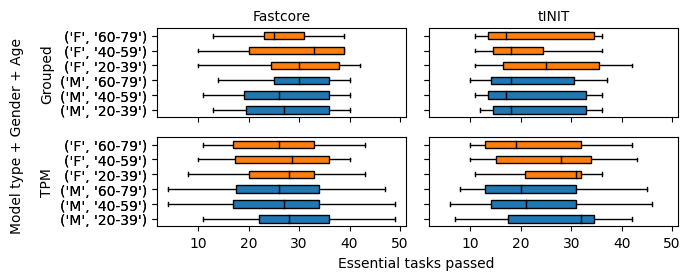

In [99]:
fig, ax = plt.subplots(2,2,figsize=(7,3),sharey="row",sharex=True)
from itertools import product
labels = list(product(["M","F"], ["20-39","40-59","60-79"]))
# blue = dict(linestyle='-', linewidth=1, color='#1f77b4')
# orange = dict(linestyle='-', linewidth=1, color='#ff7f0e') #,boxprops=blue,medianprops=blue ,boxprops=orange

boxTL = ax[0,0].boxplot([grp_tsk_temp.loc(axis=0)[:,"1","20-39"]["fastcore"],
                 grp_tsk_temp.loc(axis=0)[:,"1","40-59"]["fastcore"],
                grp_tsk_temp.loc(axis=0)[:,"1","60-79"]["fastcore"],
                 grp_tsk_temp.loc(axis=0)[:,"2","20-39"]["fastcore"],
                grp_tsk_temp.loc(axis=0)[:,"2","40-59"]["fastcore"],
                 grp_tsk_temp.loc(axis=0)[:,"2","60-79"]["fastcore"]],
                       vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})
    
boxTR = ax[0,1].boxplot([grp_tsk_temp.loc(axis=0)[:,"1","20-39"]["tinit"],
                 grp_tsk_temp.loc(axis=0)[:,"1","40-59"]["tinit"],
                grp_tsk_temp.loc(axis=0)[:,"1","60-79"]["tinit"],
                 grp_tsk_temp.loc(axis=0)[:,"2","20-39"]["tinit"],
                grp_tsk_temp.loc(axis=0)[:,"2","40-59"]["tinit"],
                 grp_tsk_temp.loc(axis=0)[:,"2","60-79"]["tinit"]],
                    vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})

boxBL = ax[1,0].boxplot([tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==1) & (tsk_temp_meta2["AGE_NEW"]=="20-39")),"fastcore"],
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==1) & (tsk_temp_meta2["AGE_NEW"]=="40-59")),"fastcore"],
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==1) & (tsk_temp_meta2["AGE_NEW"]=="60-79")),"fastcore"], 
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==2) & (tsk_temp_meta2["AGE_NEW"]=="20-39")),"fastcore"],
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==2) & (tsk_temp_meta2["AGE_NEW"]=="40-59")),"fastcore"],
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==2) & (tsk_temp_meta2["AGE_NEW"]=="60-79")),"fastcore"]],
               vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})

boxBR = ax[1,1].boxplot([tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"],
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"],
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"], 
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"],
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"],
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"]],
                       vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})


colors = ['#1f77b4']*3+["#ff7f0e"]*3
for box in [boxTL,boxTR,boxBL,boxBR]:
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

ax[0,0].set_title("Fastcore",fontsize="medium")
ax[0,1].set_title("tINIT",fontsize="medium")
ax[0,0].set_ylabel("Grouped")
ax[1,0].set_ylabel("TPM")
fig.supxlabel("Essential tasks passed",x=0.6,y=0.08,fontsize="medium")
fig.supylabel("Model type + Gender + Age",y=0.53,fontsize="medium") #

fig.tight_layout()
plt.show()

In [100]:
print("Grouped")
print(stats.kruskal(grp_tsk_temp.loc(axis=0)[:,"1","20-39"]["fastcore"],
                 grp_tsk_temp.loc(axis=0)[:,"1","40-59"]["fastcore"],
                grp_tsk_temp.loc(axis=0)[:,"1","60-79"]["fastcore"],
                 grp_tsk_temp.loc(axis=0)[:,"2","20-39"]["fastcore"],
                grp_tsk_temp.loc(axis=0)[:,"2","40-59"]["fastcore"],
                 grp_tsk_temp.loc(axis=0)[:,"2","60-79"]["fastcore"]))
print(stats.kruskal(grp_tsk_temp.loc(axis=0)[:,"1","20-39"]["tinit"],
                 grp_tsk_temp.loc(axis=0)[:,"1","40-59"]["tinit"],
                grp_tsk_temp.loc(axis=0)[:,"1","60-79"]["tinit"],
                 grp_tsk_temp.loc(axis=0)[:,"2","20-39"]["tinit"],
                grp_tsk_temp.loc(axis=0)[:,"2","40-59"]["tinit"],
                 grp_tsk_temp.loc(axis=0)[:,"2","60-79"]["tinit"]))

Grouped
KruskalResult(statistic=1.1632098140887797, pvalue=0.9483578131237878)
KruskalResult(statistic=1.3825211748934298, pvalue=0.92621567761959)


In [101]:
print("TPM")
print(stats.kruskal(tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==1) & (tsk_temp_meta2["AGE_NEW"]=="20-39")),"fastcore"],
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==1) & (tsk_temp_meta2["AGE_NEW"]=="40-59")),"fastcore"],
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==1) & (tsk_temp_meta2["AGE_NEW"]=="60-79")),"fastcore"], 
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==2) & (tsk_temp_meta2["AGE_NEW"]=="20-39")),"fastcore"],
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==2) & (tsk_temp_meta2["AGE_NEW"]=="40-59")),"fastcore"],
               tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==2) & (tsk_temp_meta2["AGE_NEW"]=="60-79")),"fastcore"]))
print(stats.kruskal(tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"],
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"],
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"], 
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"],
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"],
               tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"]))

TPM
KruskalResult(statistic=4.610780593153222, pvalue=0.4651995566471221)
KruskalResult(statistic=12.719055024156873, pvalue=0.02615869642546598)


In [102]:
temp = sp.posthoc_dunn([tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"],
       tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"],
       tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"], 
       tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"],
       tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"],
       tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"]],
        p_adjust = 'fdr_bh')
temp

,1,2,3,4,5,6
1,1.000000,0.062869,0.038088,0.974659,0.467252,0.062869
2,0.062869,1.000000,0.724087,0.351609,0.393161,0.862934
3,0.038088,0.724087,1.000000,0.348662,0.348662,0.862934
4,0.974659,0.351609,0.348662,1.000000,0.724087,0.351609
5,0.467252,0.393161,0.348662,0.724087,1.000000,0.351609
6,0.062869,0.862934,0.862934,0.351609,0.351609,1.000000


In [103]:
print("Significant?")
print(temp < 0.05)
del temp

Significant?
       1      2      3      4      5      6
1  False  False   True  False  False  False
2  False  False  False  False  False  False
3   True  False  False  False  False  False
4  False  False  False  False  False  False
5  False  False  False  False  False  False
6  False  False  False  False  False  False


#### Full tasks: non-minimal models Kruskal 

In [104]:
print(stats.kruskal(tpm_ftemp.sum(axis=1).loc(axis=0)["ft",:],tpm_ftemp.sum(axis=1).loc(axis=0)["tinit",:],
                    med_ftemp.sum(axis=1).loc(axis=0)["ft",:],med_ftemp.sum(axis=1).loc(axis=0)["tinit",:],
                    grp_ftemp.sum(axis=1).loc(axis=0)["ft",:],grp_ftemp.sum(axis=1).loc(axis=0)["tinit",:]
))

KruskalResult(statistic=11.942885159385085, pvalue=0.035578822344708314)


In [105]:
res_full = sp.posthoc_dunn([tpm_ftemp.sum(axis=1).loc(axis=0)["ft",:],tpm_ftemp.sum(axis=1).loc(axis=0)["tinit",:],
                    med_ftemp.sum(axis=1).loc(axis=0)["ft",:],med_ftemp.sum(axis=1).loc(axis=0)["tinit",:],
                    grp_ftemp.sum(axis=1).loc(axis=0)["ft",:],grp_ftemp.sum(axis=1).loc(axis=0)["tinit",:]],
                          p_adjust = 'fdr_bh').rename(
    index={1:"FT TPM",2:"tINIT TPM",3:"FT MED",4:"tINIT MED",5:"FT GRP",6:"tINIT GRP"},
    columns={1:"FT TPM",2:"tINIT TPM",3:"FT MED",4:"tINIT MED",5:"FT GRP",6:"tINIT GRP"})
res_full

,FT TPM,tINIT TPM,FT MED,tINIT MED,FT GRP,tINIT GRP
FT TPM,1.000000,0.104237,0.952234,0.736455,0.519868,0.247720
tINIT TPM,0.104237,1.000000,0.786721,0.790089,0.104237,0.786721
FT MED,0.952234,0.786721,1.000000,0.786721,0.790089,0.786721
tINIT MED,0.736455,0.790089,0.786721,1.000000,0.496259,0.942043
FT GRP,0.519868,0.104237,0.790089,0.496259,1.000000,0.104237
tINIT GRP,0.247720,0.786721,0.786721,0.942043,0.104237,1.000000


In [106]:
# res_full.to_clipboard()

In [107]:
print("Significantly different?")
res_full < 0.05

Significantly different?


,FT TPM,tINIT TPM,FT MED,tINIT MED,FT GRP,tINIT GRP
FT TPM,False,False,False,False,False,False
tINIT TPM,False,False,False,False,False,False
FT MED,False,False,False,False,False,False
tINIT MED,False,False,False,False,False,False
FT GRP,False,False,False,False,False,False
tINIT GRP,False,False,False,False,False,False


#### Full tasks: minimal vs non-minimal (TPM)

In [108]:
min_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                       "gtl50_gtu90_lt50_fttinit_rin6_min_full_nodrugex.json")))
min_full.index = min_csm.index
min_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

In [109]:
print("Minimal fastcore:\n",min_full.loc(axis=0)["fastcore"].sum(axis=1).describe(),end="\n\n")
print("Minimal tinit:\n",min_full.loc(axis=0)["tinit"].sum(axis=1).describe())

Minimal fastcore:
 count    40.000000
mean     53.875000
std       2.830126
min      48.000000
25%      51.000000
50%      54.000000
75%      56.000000
max      60.000000
dtype: float64

Minimal tinit:
 count     40.000000
mean     102.050000
std       40.923913
min       49.000000
25%       55.750000
50%      113.000000
75%      130.000000
max      177.000000
dtype: float64


In [110]:
print(stats.mannwhitneyu(x=tpm_ftemp.loc(axis=0)["ft",min_vs_prot.loc(axis=1)["MIN","fastcore"].index].sum(axis=1),
                     y=min_full.loc(axis=0)["fastcore"].sum(axis=1),alternative='greater'))
print(stats.mannwhitneyu(x=tpm_ftemp.loc(axis=0)["tinit",min_vs_prot.loc(axis=1)["MIN","fastcore"].index].sum(axis=1),
                     y=min_full.loc(axis=0)["tinit"].sum(axis=1),alternative='greater'))

MannwhitneyuResult(statistic=1571.5, pvalue=5.3419329821372055e-14)
MannwhitneyuResult(statistic=956.5, pvalue=0.06658155574134493)


In [111]:
print(stats.mannwhitneyu(x=tpm_ftemp.loc(axis=0)["ft"].sum(axis=1),
                     y=min_full.loc(axis=0)["fastcore"].sum(axis=1),alternative='greater'))
print(stats.mannwhitneyu(x=tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1),
                     y=min_full.loc(axis=0)["tinit"].sum(axis=1),alternative='greater'))

MannwhitneyuResult(statistic=21742.5, pvalue=2.6809650065572078e-20)
MannwhitneyuResult(statistic=7891.5, pvalue=0.10501101860325601)


#### Full tasks: by metadata

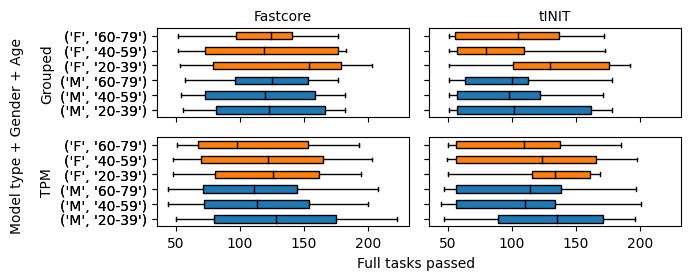

In [112]:
fig, ax = plt.subplots(2,2,figsize=(7,3),sharey="row",sharex=True)
from itertools import product
labels = list(product(["M","F"], ["20-39","40-59","60-79"]))
# blue = dict(linestyle='-', linewidth=1, color='#1f77b4')
# orange = dict(linestyle='-', linewidth=1, color='#ff7f0e') #,boxprops=blue,medianprops=blue ,boxprops=orange

boxTL = ax[0,0].boxplot([grp_ftemp.loc(axis=0)["ft",:,"1","20-39"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["ft",:,"1","40-59"].sum(axis=1),
                grp_ftemp.loc(axis=0)["ft",:,"1","60-79"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["ft",:,"2","20-39"].sum(axis=1),
                grp_ftemp.loc(axis=0)["ft",:,"2","40-59"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["ft",:,"2","60-79"].sum(axis=1)],
                       vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})
    
boxTR = ax[0,1].boxplot([grp_ftemp.loc(axis=0)["tinit",:,"1","20-39"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["tinit",:,"1","40-59"].sum(axis=1),
                grp_ftemp.loc(axis=0)["tinit",:,"1","60-79"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["tinit",:,"2","20-39"].sum(axis=1),
                grp_ftemp.loc(axis=0)["tinit",:,"2","40-59"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["tinit",:,"2","60-79"].sum(axis=1)],
                    vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})

boxBL = ax[1,0].boxplot([tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
    tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==1) & (tsk_temp_meta2["AGE_NEW"]=="20-39")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==1) & (tsk_temp_meta2["AGE_NEW"]=="40-59")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==1) & (tsk_temp_meta2["AGE_NEW"]=="60-79")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==2) & (tsk_temp_meta2["AGE_NEW"]=="20-39")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==2) & (tsk_temp_meta2["AGE_NEW"]=="40-59")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta2.loc[((tsk_temp_meta2["SEX"]==2) & (tsk_temp_meta2["AGE_NEW"]=="60-79")),"fastcore"].index]],
               vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})

boxBR = ax[1,1].boxplot([tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
    tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"].index]],
                       vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})


colors = ['#1f77b4']*3+["#ff7f0e"]*3
for box in [boxTL,boxTR,boxBL,boxBR]: #:
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

ax[0,0].set_title("Fastcore",fontsize="medium")
ax[0,1].set_title("tINIT",fontsize="medium")
ax[0,0].set_ylabel("Grouped")
ax[1,0].set_ylabel("TPM")
fig.supxlabel("Full tasks passed",x=0.6,y=0.08,fontsize="medium")
fig.supylabel("Model type + Gender + Age",y=0.53,fontsize="medium") #

fig.tight_layout()
plt.show()

In [113]:
print("Grouped")
print(stats.kruskal(grp_ftemp.loc(axis=0)["ft",:,"1","20-39"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["ft",:,"1","40-59"].sum(axis=1),
                grp_ftemp.loc(axis=0)["ft",:,"1","60-79"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["ft",:,"2","20-39"].sum(axis=1),
                grp_ftemp.loc(axis=0)["ft",:,"2","40-59"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["ft",:,"2","60-79"].sum(axis=1) ))

print(stats.kruskal(grp_ftemp.loc(axis=0)["tinit",:,"1","20-39"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["tinit",:,"1","40-59"].sum(axis=1),
                grp_ftemp.loc(axis=0)["tinit",:,"1","60-79"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["tinit",:,"2","20-39"].sum(axis=1),
                grp_ftemp.loc(axis=0)["tinit",:,"2","40-59"].sum(axis=1),
                 grp_ftemp.loc(axis=0)["tinit",:,"2","60-79"].sum(axis=1) ))

Grouped
KruskalResult(statistic=1.1079159001014098, pvalue=0.9534006102958417)
KruskalResult(statistic=2.321490405287656, pvalue=0.8031054120059309)


In [114]:
print("TPM")
print(stats.kruskal(tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
    tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"fastcore"].index],
    tpm_ftemp.loc(axis=0)["ft"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"fastcore"].index] ))

print(stats.kruskal(tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
    tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"].index] ))

TPM
KruskalResult(statistic=9.078072679504826, pvalue=0.10599032985429958)
KruskalResult(statistic=12.971096036752556, pvalue=0.023651140321414056)


In [115]:
res_tinit_tpm = sp.posthoc_dunn([tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
    tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==1) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="20-39")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="40-59")),"tinit"].index],
    tpm_ftemp.loc(axis=0)["tinit"].sum(axis=1).loc[
        tsk_temp_meta.loc[((tsk_temp_meta["SEX"]==2) & (tsk_temp_meta["AGE_NEW"]=="60-79")),"tinit"].index]]
                               , p_adjust = 'fdr_bh').rename(
    index={1:"M_20-39",2:"M_40-59",3:"M_60-79",4:"F_20-39",5:"F_40-59",6:"F_60-79"},
    columns={1:"M_20-39",2:"M_40-59",3:"M_60-79",4:"F_20-39",5:"F_40-59",6:"F_60-79"})
res_tinit_tpm

,M_20-39,M_40-59,M_60-79,F_20-39,F_40-59,F_60-79
M_20-39,1.000000,0.030889,0.030889,0.966167,0.377430,0.030889
M_40-59,0.030889,1.000000,0.966167,0.296227,0.377430,0.966167
M_60-79,0.030889,0.966167,1.000000,0.296227,0.377430,0.966167
F_20-39,0.966167,0.296227,0.296227,1.000000,0.544654,0.296227
F_40-59,0.377430,0.377430,0.377430,0.544654,1.000000,0.377430
F_60-79,0.030889,0.966167,0.966167,0.296227,0.377430,1.000000


In [116]:
print("Significant?")
res_tinit_tpm < 0.05

Significant?


,M_20-39,M_40-59,M_60-79,F_20-39,F_40-59,F_60-79
M_20-39,False,True,True,False,False,True
M_40-59,True,False,False,False,False,False
M_60-79,True,False,False,False,False,False
F_20-39,False,False,False,False,False,False
F_40-59,False,False,False,False,False,False
F_60-79,True,False,False,False,False,False


#### Full tasks: HK vs non-HK

In [117]:
#formely HK vs non-HK
hk_ft = tpm_ftemp.loc(axis=0)["ft"]["HK"].sum(axis=1)/192*100
hk_ft_med = med_ftemp.loc(axis=0)["ft"]["HK"].sum(axis=1)/192*100
hk_ft_grp = grp_ftemp.loc(axis=0)["ft"]["HK"].sum(axis=1)/192*100

hk_tinit = tpm_ftemp.loc(axis=0)["tinit"]["HK"].sum(axis=1)/192*100
hk_tinit_med = med_ftemp.loc(axis=0)["tinit"]["HK"].sum(axis=1)/192*100
hk_tinit_grp = grp_ftemp.loc(axis=0)["tinit"]["HK"].sum(axis=1)/192*100

In [118]:
nonhk_ft = tpm_ftemp.loc(axis=0)["ft"]["Other"].sum(axis=1)/64*100
nonhk_ft_med = med_ftemp.loc(axis=0)["ft"]["Other"].sum(axis=1)/64*100
nonhk_ft_grp = grp_ftemp.loc(axis=0)["ft"]["Other"].sum(axis=1)/64*100

nonhk_tinit = tpm_ftemp.loc(axis=0)["tinit"]["Other"].sum(axis=1)/64*100
nonhk_tinit_med = med_ftemp.loc(axis=0)["tinit"]["Other"].sum(axis=1)/64*100
nonhk_tinit_grp = grp_ftemp.loc(axis=0)["tinit"]["Other"].sum(axis=1)/64*100

In [119]:
print("TPM")
print(stats.wilcoxon(y=hk_ft,x=nonhk_ft,alternative="greater"))
print(stats.wilcoxon(y=hk_tinit,x=nonhk_tinit,alternative="greater"))

TPM
WilcoxonResult(statistic=147419.5, pvalue=3.038791401709433e-60)
WilcoxonResult(statistic=61030.0, pvalue=7.515497787933341e-57)


In [120]:
print("Grouped")
print(stats.wilcoxon(y=hk_ft_grp,x=nonhk_ft_grp,alternative="greater"))
print(stats.wilcoxon(y=hk_tinit_grp,x=nonhk_tinit_grp,alternative="greater"))

Grouped
WilcoxonResult(statistic=2043.5, pvalue=1.0236569480450343e-09)
WilcoxonResult(statistic=2211.0, pvalue=8.076951267318153e-13)


In [121]:
print("Median")
print(stats.wilcoxon(y=hk_ft_med,x=nonhk_ft_med,alternative="greater"))
print(stats.wilcoxon(y=hk_tinit_med,x=nonhk_tinit_med,alternative="greater"))

Median
WilcoxonResult(statistic=66.0, pvalue=0.00048828125)
WilcoxonResult(statistic=66.0, pvalue=0.00048828125)


In [122]:
hk_h1 = h1_rc_full.loc[:,tpm_ftemp["HK"].columns].sum(axis=1)/192*100
nonhk_h1 = h1_rc_full.loc[:,tpm_ftemp["Other"].columns].sum(axis=1)/64*100
hk_h1_mat = h1_rc_full_mat.loc[:,tpm_ftemp["HK"].columns].sum(axis=1)/192*100
nonhk_h1_mat = h1_rc_full_mat.loc[:,tpm_ftemp["Other"].columns].sum(axis=1)/64*100

In [123]:
print("H1-CSMs - Troppo")
print(stats.wilcoxon(y=hk_h1,x=nonhk_h1,alternative="greater"))

H1-CSMs - Troppo
WilcoxonResult(statistic=66.0, pvalue=0.00048828125)


#### Control for variance threshold filter + Omics data models

In [124]:
med_1tpm_full = tasks_to_df(pd.read_json(os.path.join(ROOT_FOLDER,"DATA","results",
                                                       "gtl50_gtu90_lt50_fttinit_med_1tpmthresh_full_nodrugex.json")))
med_1tpm_full.index = med_1tpm.index
med_1tpm_full.columns = valid_tdf.loc[~valid_tdf["DESCRIPTION"].isna(),"DESCRIPTION"]

In [125]:
print(ft_prmat_full.sum(axis=1).mean(),ft_prmat_novar_full.sum(axis=1).mean(),ft_prmat_1tpm_full.sum(axis=1).mean(),
med_1tpm_full.loc(axis=0)["fastcore"].sum(axis=1).mean(),med_1tpm_full.loc(axis=0)["tinit"].sum(axis=1).mean())

136.19811320754718 136.62735849056602 206.8679245283019 206.63636363636363 245.72727272727272


In [126]:
print("Median omics CSMs - tasks neither passed nor failed by all:")
print("Fastcore")
temp = med_1tpm_full.loc(axis=0)["fastcore"]
print("\tHK:",
      temp.loc[:,(~med_1tpm_full.all() & temp.any() & temp.columns.isin(hk_full_tsks))].shape[1],"(",
     temp.loc[:,(~med_1tpm_full.all() & temp.any() & temp.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      temp.loc[:,(~temp.all() & temp.any() & ~temp.columns.isin(hk_full_tsks))].shape[1],"(",
     temp.loc[:,(~temp.all() & temp.any() & ~temp.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
print("tINIT")
temp = med_1tpm_full.loc(axis=0)["tinit"]
print("\tHK:",
      temp.loc[:,(~med_1tpm_full.all() & temp.any() & temp.columns.isin(hk_full_tsks))].shape[1],"(",
     temp.loc[:,(~med_1tpm_full.all() & temp.any() & temp.columns.isin(hk_full_tsks))].shape[1]/192*100,"% )") 
print("\tOther:",
      temp.loc[:,(~temp.all() & temp.any() & ~temp.columns.isin(hk_full_tsks))].shape[1],"(",
     temp.loc[:,(~temp.all() & temp.any() & ~temp.columns.isin(hk_full_tsks))].shape[1]/64*100,"% )") 
del temp

Median omics CSMs - tasks neither passed nor failed by all:
Fastcore
	HK: 61 ( 31.770833333333332 % )
	Other: 6 ( 9.375 % )
tINIT
	HK: 61 ( 31.770833333333332 % )
	Other: 1 ( 1.5625 % )


In [127]:
print("Reactions")
print(stats.kruskal(ft_prmat.sum(axis=1),ft_prmat_novar.sum(axis=1),ft_prmat_1tpm.sum(axis=1),ft_prmat_1tpm_NB.sum(axis=1),
                   med_1tpm.loc(axis=0)["fastcore"].sum(axis=1),med_1tpm.loc(axis=0)["tinit"].sum(axis=1),
                   med_1tpm_NB_ft.sum(axis=1),med_1tpm_NB_tinit.sum(axis=1)))
print("Essential tasks")
print(stats.kruskal(ft_prmat_tasks.sum(axis=1),ft_prmat_novar_tsk.sum(axis=1),ft_prmat_1tpm_tsk.sum(axis=1),
                    med_1tpm_tsk.loc(axis=0)["fastcore"].sum(axis=1),med_1tpm_tsk.loc(axis=0)["tinit"].sum(axis=1),
                   h1_rc_ess.sum(axis=1)))
print("Full tasks")
print(stats.kruskal(ft_prmat_full.sum(axis=1),ft_prmat_novar_full.sum(axis=1),ft_prmat_1tpm_full.sum(axis=1),
                    med_1tpm_full.loc(axis=0)["fastcore"].sum(axis=1),med_1tpm_full.loc(axis=0)["tinit"].sum(axis=1),
                   h1_rc_full.sum(axis=1)))

Reactions
KruskalResult(statistic=661.4054486599236, pvalue=1.4385848064107597e-138)
Essential tasks
KruskalResult(statistic=350.881137508041, pvalue=1.1308259956710617e-73)
Full tasks
KruskalResult(statistic=466.0262706363855, pvalue=1.7135952251601447e-98)


In [128]:
print("Reactions")
res_om_rc = sp.posthoc_dunn([ft_prmat.sum(axis=1),ft_prmat_novar.sum(axis=1),ft_prmat_1tpm.sum(axis=1),
ft_prmat_1tpm_NB.sum(axis=1), med_1tpm.loc(axis=0)["fastcore"].sum(axis=1),med_1tpm.loc(axis=0)["tinit"].sum(axis=1),
                   med_1tpm_NB_ft.sum(axis=1),med_1tpm_NB_tinit.sum(axis=1)],
                            p_adjust = 'fdr_bh').rename(
    index={1:"FT TPM-GS",2:"FT TPM-GS-NV",3:"FT TPM-OM",4:"FT TPM-OM-NB",5:"FT MED-OM",6:"tINIT MED-OM",7:"FT MED-OM-NB",8:"tINIT MED-OM-NB"},
columns={1:"FT TPM-GS",2:"FT TPM-GS-NV",3:"FT TPM-OM",4:"FT TPM-OM-NB",5:"FT MED-OM",6:"tINIT MED-OM",7:"FT MED-OM-NB",8:"tINIT MED-OM-NB"})
res_om_rc

Reactions


,FT TPM-GS,FT TPM-GS-NV,FT TPM-OM,FT TPM-OM-NB,FT MED-OM,tINIT MED-OM,FT MED-OM-NB,tINIT MED-OM-NB
FT TPM-GS,1.000000e+00,1.091473e-01,9.249047e-51,3.100933e-20,5.637512e-05,1.749345e-09,6.925222e-01,0.692522
FT TPM-GS-NV,1.091473e-01,1.000000e+00,5.926073e-40,4.425265e-28,5.119956e-04,4.559933e-08,3.965021e-01,0.913386
FT TPM-OM,9.249047e-51,5.926073e-40,1.000000e+00,1.008229e-131,6.374799e-01,1.844059e-01,5.871563e-07,0.000037
FT TPM-OM-NB,3.100933e-20,4.425265e-28,1.008229e-131,1.000000e+00,3.624205e-12,2.183906e-19,1.715696e-02,0.001193
FT MED-OM,5.637512e-05,5.119956e-04,6.374799e-01,3.624205e-12,1.000000e+00,1.844059e-01,1.324147e-03,0.010230
tINIT MED-OM,1.749345e-09,4.559933e-08,1.844059e-01,2.183906e-19,1.844059e-01,1.000000e+00,3.626624e-06,0.000056
FT MED-OM-NB,6.925222e-01,3.965021e-01,5.871563e-07,1.715696e-02,1.324147e-03,3.626624e-06,1.000000e+00,0.613855
tINIT MED-OM-NB,6.925222e-01,9.133859e-01,3.699180e-05,1.192893e-03,1.023025e-02,5.637512e-05,6.138555e-01,1.000000


In [138]:
# res_om_rc.to_clipboard()

In [130]:
print("Significantly different?")
res_om_rc < 0.05

Significantly different?


,FT TPM-GS,FT TPM-GS-NV,FT TPM-OM,FT TPM-OM-NB,FT MED-OM,tINIT MED-OM,FT MED-OM-NB,tINIT MED-OM-NB
FT TPM-GS,False,False,True,True,True,True,False,False
FT TPM-GS-NV,False,False,True,True,True,True,False,False
FT TPM-OM,True,True,False,True,False,False,True,True
FT TPM-OM-NB,True,True,True,False,True,True,True,True
FT MED-OM,True,True,False,True,False,False,True,True
tINIT MED-OM,True,True,False,True,False,False,True,True
FT MED-OM-NB,False,False,True,True,True,True,False,False
tINIT MED-OM-NB,False,False,True,True,True,True,False,False


In [131]:
print("Proportion of blocked reactions by algorithm")
print(stats.mannwhitneyu(
x=(med_1tpm.loc(axis=0)["fastcore"].sum(axis=1)-med_1tpm_NB_ft.sum(axis=1))/med_1tpm.loc(axis=0)["fastcore"].sum(axis=1)*100,
y=(med_1tpm.loc(axis=0)["tinit"].sum(axis=1)-med_1tpm_NB_tinit.sum(axis=1))/med_1tpm.loc(axis=0)["tinit"].sum(axis=1)*100,
alternative="less"))

Proportion of blocked reactions by algorithm
MannwhitneyuResult(statistic=52.0, pvalue=0.29968034821451794)


In [132]:
print("Essential tasks")
res_om_tsk = sp.posthoc_dunn([ft_prmat_tasks.sum(axis=1),ft_prmat_novar_tsk.sum(axis=1),ft_prmat_1tpm_tsk.sum(axis=1),
                    med_1tpm_tsk.loc(axis=0)["fastcore"].sum(axis=1),med_1tpm_tsk.loc(axis=0)["tinit"].sum(axis=1),
                             h1_rc_ess.sum(axis=1)],
                      p_adjust = 'fdr_bh').rename(
    index={1:"FT TPM-GS",2:"FT TPM-GS-NV",3:"FT TPM-OM",4:"FT MED-OM",5:"tINIT MED-OM",6:"H1-CSMs"},
    columns={1:"FT TPM-GS",2:"FT TPM-GS-NV",3:"FT TPM-OM",4:"FT MED-OM",5:"tINIT MED-OM",6:"H1-CSMs"})
res_om_tsk

Essential tasks


,FT TPM-GS,FT TPM-GS-NV,FT TPM-OM,FT MED-OM,tINIT MED-OM,H1-CSMs
FT TPM-GS,1.000000e+00,9.096334e-01,2.621006e-46,0.000005,3.555607e-12,1.884751e-12
FT TPM-GS-NV,9.096334e-01,1.000000e+00,1.086521e-45,0.000006,4.127568e-12,1.983092e-12
FT TPM-OM,2.621006e-46,1.086521e-45,1.000000e+00,0.909633,1.567231e-02,1.097488e-02
FT MED-OM,5.173922e-06,5.666521e-06,9.096334e-01,1.000000,1.035087e-01,8.806895e-02
tINIT MED-OM,3.555607e-12,4.127568e-12,1.567231e-02,0.103509,1.000000e+00,9.096334e-01
H1-CSMs,1.884751e-12,1.983092e-12,1.097488e-02,0.088069,9.096334e-01,1.000000e+00


In [139]:
# res_om_tsk.to_clipboard()

In [134]:
print("Significantly different?")
res_om_tsk < 0.05

Significantly different?


,FT TPM-GS,FT TPM-GS-NV,FT TPM-OM,FT MED-OM,tINIT MED-OM,H1-CSMs
FT TPM-GS,False,False,True,True,True,True
FT TPM-GS-NV,False,False,True,True,True,True
FT TPM-OM,True,True,False,False,True,True
FT MED-OM,True,True,False,False,False,False
tINIT MED-OM,True,True,True,False,False,False
H1-CSMs,True,True,True,False,False,False


In [135]:
print("Full tasks")
res_om_full = sp.posthoc_dunn([ft_prmat_full.sum(axis=1),ft_prmat_novar_full.sum(axis=1),ft_prmat_1tpm_full.sum(axis=1),
                    med_1tpm_full.loc(axis=0)["fastcore"].sum(axis=1),med_1tpm_full.loc(axis=0)["tinit"].sum(axis=1),
                              h1_rc_full.sum(axis=1)],
                      p_adjust = 'fdr_bh').rename(
    index={1:"FT TPM-GS",2:"FT TPM-GS-NV",3:"FT TPM-OM",4:"FT MED-OM",5:"tINIT MED-OM",6:"H1-CSMs"},
    columns={1:"FT TPM-GS",2:"FT TPM-GS-NV",3:"FT TPM-OM",4:"FT MED-OM",5:"tINIT MED-OM",6:"H1-CSMs"})
res_om_full

Full tasks


,FT TPM-GS,FT TPM-GS-NV,FT TPM-OM,FT MED-OM,tINIT MED-OM,H1-CSMs
FT TPM-GS,1.000000e+00,7.783055e-01,2.110425e-66,6.704325e-07,2.305117e-13,5.975825e-12
FT TPM-GS-NV,7.783055e-01,1.000000e+00,1.370462e-64,9.336638e-07,3.393633e-13,9.353498e-12
FT TPM-OM,2.110425e-66,1.370462e-64,1.000000e+00,7.783055e-01,6.149650e-02,1.557776e-01
FT MED-OM,6.704325e-07,9.336638e-07,7.783055e-01,1.000000e+00,1.175878e-01,2.048749e-01
tINIT MED-OM,2.305117e-13,3.393633e-13,6.149650e-02,1.175878e-01,1.000000e+00,7.783055e-01
H1-CSMs,5.975825e-12,9.353498e-12,1.557776e-01,2.048749e-01,7.783055e-01,1.000000e+00


In [140]:
# res_om_full.to_clipboard()

In [137]:
print("Significantly different?")
res_om_full < 0.05

Significantly different?


,FT TPM-GS,FT TPM-GS-NV,FT TPM-OM,FT MED-OM,tINIT MED-OM,H1-CSMs
FT TPM-GS,False,False,True,True,True,True
FT TPM-GS-NV,False,False,True,True,True,True
FT TPM-OM,True,True,False,False,False,False
FT MED-OM,True,True,False,False,False,False
tINIT MED-OM,True,True,False,False,False,False
H1-CSMs,True,True,False,False,False,False


Omics data models: HK vs non-HK full tasks

In [140]:
# med_1tpm_full.loc(axis=0)["fastcore"].sum(axis=1),med_1tpm_full.loc(axis=0)["tinit"].sum(axis=1)
print((ft_prmat_1tpm_full.loc[:,ft_prmat_1tpm_full.columns.isin(hk_full_tsks)].sum(axis=1)/192*100).describe(),end="\n\n")
print((ft_prmat_1tpm_full.loc[:,~ft_prmat_1tpm_full.columns.isin(hk_full_tsks)].sum(axis=1)/64*100).describe())

count    212.000000
mean      77.454304
std        4.166582
min       70.833333
25%       75.520833
50%       77.083333
75%       78.645833
max       94.791667
dtype: float64

count    212.000000
mean      90.868219
std        1.074933
min       89.062500
25%       90.625000
50%       90.625000
75%       90.625000
max       95.312500
dtype: float64


In [146]:
print("TPM")
print(stats.wilcoxon(y=ft_prmat_1tpm_full.loc[:,ft_prmat_1tpm_full.columns.isin(hk_full_tsks)].sum(axis=1)/192*100,
      x=ft_prmat_1tpm_full.loc[:,~ft_prmat_1tpm_full.columns.isin(hk_full_tsks)].sum(axis=1)/64*100,alternative="greater"))
print("Median fastcore")
print(stats.wilcoxon(y=med_1tpm_full.loc(axis=0)["fastcore"].loc[:,
         med_1tpm_full.columns.isin(hk_full_tsks)].sum(axis=1)/192*100,
      x=med_1tpm_full.loc(axis=0)["fastcore"].loc[:,
         ~med_1tpm_full.columns.isin(hk_full_tsks)].sum(axis=1)/64*100,alternative="greater"))
print("Median tinit")
print(stats.wilcoxon(y=med_1tpm_full.loc(axis=0)["tinit"].loc[:,
         med_1tpm_full.columns.isin(hk_full_tsks)].sum(axis=1)/192*100,
      x=med_1tpm_full.loc(axis=0)["tinit"].loc[:,
         ~med_1tpm_full.columns.isin(hk_full_tsks)].sum(axis=1)/64*100,alternative="greater"))

TPM
WilcoxonResult(statistic=22578.0, pvalue=5.4930586830984456e-37)
Median fastcore
WilcoxonResult(statistic=66.0, pvalue=0.00048828125)
Median tinit
WilcoxonResult(statistic=10.0, pvalue=0.98388671875)


FT Omics TPM models: by metadata

In [118]:
tsk_temp_meta3 = tsk_temp_meta2.loc[ft_prmat_1tpm_tsk.index,:]
tsk_temp_meta3.loc[:,["SEX","AGE_NEW"]].value_counts().sort_index()

SEX  AGE_NEW
1    20-39      25
     40-59      53
     60-79      66
2    20-39       5
     40-59      28
     60-79      35
dtype: int64

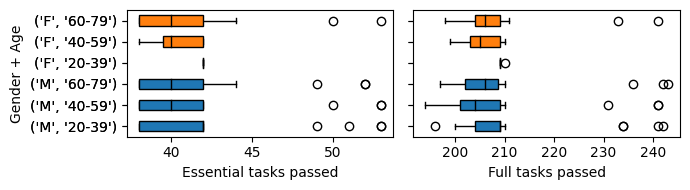

In [139]:
#OMICS FT TASKS BY METADATA
fig, ax = plt.subplots(1,2,figsize=(7,2),sharey=True)
from itertools import product
labels = list(product(["M","F"], ["20-39","40-59","60-79"]))

box1 = ax[0].boxplot([ft_prmat_1tpm_tsk.sum(axis=1).loc[
    tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index]],
               vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})

box2 = ax[1].boxplot([ft_prmat_1tpm_full.sum(axis=1).loc[
    tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index]],
               vert=False,labels=labels, patch_artist=True,medianprops={"color":"black"})

colors = ['#1f77b4']*3+["#ff7f0e"]*3
for box in [box1,box2]:
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

# ax[0].set_xlim(35,55)
# ax[1].set_xlim(190,250)
ax[0].set_xlabel("Essential tasks passed",fontsize="medium")
ax[1].set_xlabel("Full tasks passed",fontsize="medium")
ax[0].set_ylabel("Gender + Age")
# fig.supylabel("Gender + Age",y=0.53,fontsize="medium")

fig.tight_layout()
plt.show()        

In [119]:
print(stats.kruskal(ft_prmat_1tpm_tsk.sum(axis=1).loc[
    tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_tsk.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index]))
print(stats.kruskal(ft_prmat_1tpm_full.sum(axis=1).loc[
    tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index]))

KruskalResult(statistic=8.325356066762092, pvalue=0.1391927825736316)
KruskalResult(statistic=14.004054605118968, pvalue=0.015583681216988826)


In [129]:
print("Full tasks")
res_fim = sp.posthoc_dunn([ft_prmat_1tpm_full.sum(axis=1).loc[
    tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==1) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="20-39")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="40-59")),"fastcore"].index],
    ft_prmat_1tpm_full.sum(axis=1).loc[
        tsk_temp_meta3.loc[((tsk_temp_meta3["SEX"]==2) & (tsk_temp_meta3["AGE_NEW"]=="60-79")),"fastcore"].index]],
                      p_adjust = 'fdr_bh').rename(
    index=dict(zip(range(1,len(labels)+1),labels)),columns=dict(zip(range(1,len(labels)+1),labels)))
res_fim

Full tasks


,"(M, 20-39)","(M, 40-59)","(M, 60-79)","(F, 20-39)","(F, 40-59)","(F, 60-79)"
"(M, 20-39)",1.000000,0.074893,0.186421,0.255322,0.475536,0.531560
"(M, 40-59)",0.074893,1.000000,0.339468,0.069422,0.188404,0.150762
"(M, 60-79)",0.186421,0.339468,1.000000,0.087726,0.531560,0.388223
"(F, 20-39)",0.255322,0.069422,0.087726,1.000000,0.157733,0.165747
"(F, 40-59)",0.475536,0.188404,0.531560,0.157733,1.000000,0.803392
"(F, 60-79)",0.531560,0.150762,0.388223,0.165747,0.803392,1.000000


In [130]:
print("Significant?")
res_fim < 0.05

Significant?


,"(M, 20-39)","(M, 40-59)","(M, 60-79)","(F, 20-39)","(F, 40-59)","(F, 60-79)"
"(M, 20-39)",False,False,False,False,False,False
"(M, 40-59)",False,False,False,False,False,False
"(M, 60-79)",False,False,False,False,False,False
"(F, 20-39)",False,False,False,False,False,False
"(F, 40-59)",False,False,False,False,False,False
"(F, 60-79)",False,False,False,False,False,False


### tSNE of Hamming distance (of reaction content)

In [182]:
print(ft_prmat.shape[0]+ft_more.shape[0],(ft_prmat.shape[0]+ft_more.shape[0])*0.05)
print(tinit_prmat.shape[0]+tinit_more.shape[0],(tinit_prmat.shape[0]+tinit_more.shape[0])*0.05)
print(grp_ft.shape[0]+grp_ft_more.shape[0],5,"-",(grp_ft.shape[0]+grp_ft_more.shape[0])*2,
      (grp_ft.shape[0]+grp_ft_more.shape[0])*2*0.05)

583 29.150000000000002
352 17.6


#### TPM by algorithm

In [34]:
pd.concat((ft_prmat,ft_more,tinit_prmat,tinit_more)).shape[0]*0.05

46.75

In [35]:
points_tpm = TSNE(perplexity=47,n_iter=5000,metric="hamming").fit_transform(
    pd.concat((ft_prmat,ft_more,tinit_prmat,tinit_more))) 

C:\Users\liamo\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


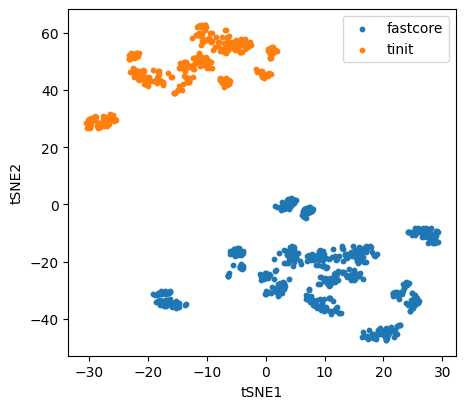

In [48]:
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
fig, ax = plt.subplots(figsize=(5,4.5)) 

temp_ft = pd.concat((ft_prmat,ft_more))
ax.scatter(points_tpm[:temp_ft.shape[0], 0], points_tpm[:temp_ft.shape[0], 1],marker='o', label="fastcore",s=10) #
ax.scatter(points_tpm[temp_ft.shape[0]:, 0], points_tpm[temp_ft.shape[0]:, 1],marker='o', label="tinit",s=10) #,alpha=0.6
del temp_ft 
   
ax.set_ylabel("tSNE2")
ax.set_xlabel("tSNE1") #,x=0.53
ax.legend()
plt.show()

#### TPM by tissue

In [109]:
points_tpm_ft = TSNE(perplexity=30,n_iter=5000,metric="hamming").fit_transform(pd.concat((ft_prmat,ft_more))) 
points_tpm_tinit = TSNE(perplexity=18,n_iter=5000,metric="hamming").fit_transform(pd.concat((tinit_prmat,tinit_more))) 

C:\Users\liamo\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning
C:\Users\liamo\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


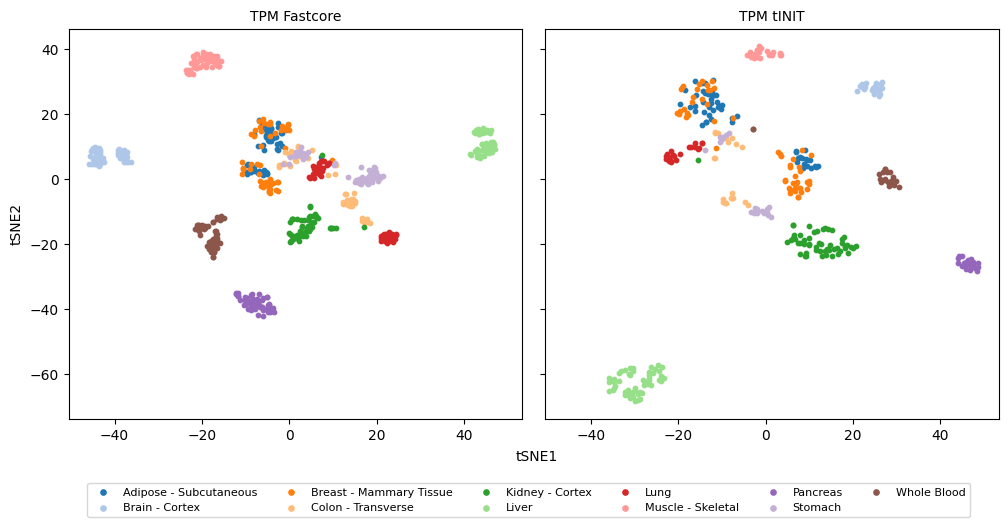

In [119]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
fig, ax = plt.subplots(1,2,figsize=(12,5),sharey=True,sharex=True) 

temp_ft = pd.concat((ft_prmat,ft_more))
for t in sorted(tissue_meta_allrin.loc[temp_ft.index,"Tissue"].unique()):
    meta_indx = tissue_meta_allrin.iloc[np.where(tissue_meta_allrin["Tissue"] == t)[0], :].index
    sp = np.where(temp_ft.index.str.contains("|".join(list(meta_indx)), case=False, regex=True))[0]
    ax[0].scatter(points_tpm_ft[sp, 0], points_tpm_ft[sp, 1],marker='o', label=t,s=10) #,alpha=0.6
del temp_ft
temp_tinit = pd.concat((tinit_prmat,tinit_more))
for t in sorted(tissue_meta_allrin.loc[temp_tinit.index,"Tissue"].unique()):
    meta_indx = tissue_meta_allrin.iloc[np.where(tissue_meta_allrin["Tissue"] == t)[0], :].index
    sp = np.where(temp_tinit.index.str.contains("|".join(list(meta_indx)), case=False, regex=True))[0]
    ax[1].scatter(points_tpm_tinit[sp, 0], points_tpm_tinit[sp, 1],marker='o', label="__nolabel__",s=10) #,alpha=0.6
del temp_tinit

ax[0].set_title("TPM Fastcore",fontsize="medium")    
ax[1].set_title("TPM tINIT",fontsize="medium")    
ax[0].set_ylabel("tSNE2")
fig.supxlabel("tSNE1",x=0.515,fontsize="medium") #,x=0.53
ax[0].legend(bbox_to_anchor=(2, -0.15),ncol=6, markerscale=1.2,fontsize=8) #bbox_to_anchor=(1.005, 1) 
fig.subplots_adjust(bottom=0.1,wspace=0.05)
plt.show()

#### Grouped

In [298]:
points_grp = TSNE(perplexity=7,n_iter=5000,metric="hamming").fit_transform(
    pd.concat((pd.concat((grp_ft,grp_ft_more)).sort_index(),pd.concat((grp_tinit,grp_tinit_more)).sort_index()   
    ))) 
points_med = TSNE(perplexity=5,n_iter=5000,metric="hamming").fit_transform(
    pd.concat((pd.concat((med_ft,med_more_ft)).sort_index(),pd.concat((med_tinit,med_more_tinit)).sort_index() 
    ))) 

C:\Users\liamo\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning
C:\Users\liamo\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


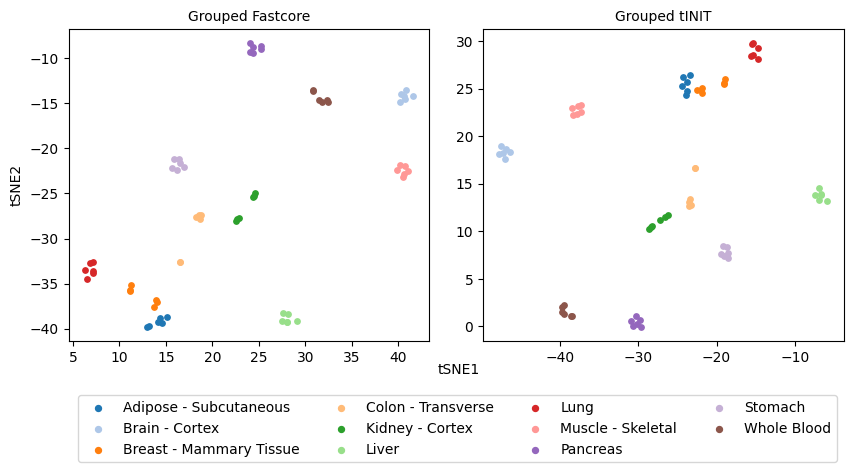

In [302]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
fig, ax = plt.subplots(1,2,figsize=(10,4))  #,sharey=True,sharex=True

grp_temp = pd.concat((grp_ft,grp_ft_more)).sort_index()
for i,t in enumerate(grp_temp.index.get_level_values(0).unique()): #GRP
    ax[0].scatter(points_grp[6*i:6*i+6, 0], points_grp[6*i:6*i+6, 1],marker='o',label=t,s=15)
    ax[1].scatter(points_grp[6*i+66:6*i+6+66, 0], points_grp[6*i+66:6*i+6+66, 1],marker='o',label=t,s=15)

ax[0].set_title("Grouped Fastcore",fontsize="medium")    
ax[1].set_title("Grouped tINIT",fontsize="medium")    
ax[0].set_ylabel("tSNE2")
fig.supxlabel("tSNE1",x=0.515,fontsize="medium") #,x=0.53
ax[0].legend(bbox_to_anchor=(2.15, -0.15),ncol=4, markerscale=1.1) #bbox_to_anchor=(1.005, 1) 
fig.subplots_adjust(bottom=0.1,wspace=0.15) #wspace=0.05
plt.show()

#### Median

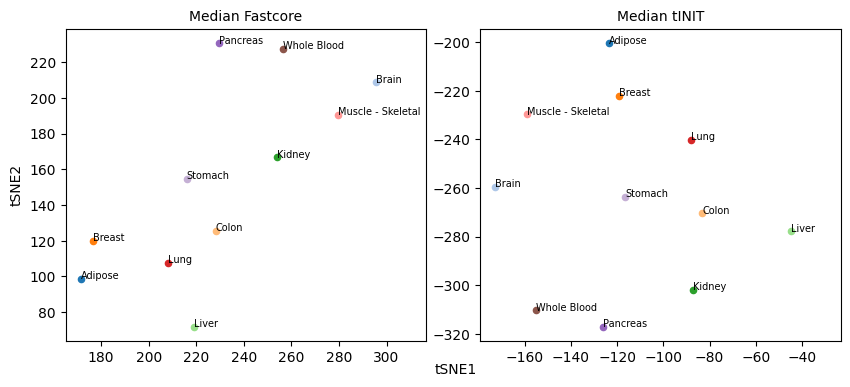

In [143]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
fig, ax = plt.subplots(1,2,figsize=(10,4)) #,sharey=True,sharex=True

for i,t in enumerate(grp_temp.index.get_level_values(0).unique()): #GRP
    ax[0].scatter(points_med[i, 0], points_med[i, 1],marker='o',label=t,s=20)
    ax[1].scatter(points_med[11+i, 0], points_med[11+i, 1],marker='o',label=t,s=20)
    if t not in ["Whole Blood","Muscle - Skeletal"]: t=t.split(" ")[0]
    ax[0].annotate(t, (points_med[i, 0], points_med[i, 1]),fontsize=7)
    ax[1].annotate(t, (points_med[11+i, 0], points_med[11+i, 1]),fontsize=7)

ax[0].set_xlim(ax[0].get_xlim()[0],ax[0].get_xlim()[1]+15)
ax[1].set_xlim(ax[1].get_xlim()[0],ax[1].get_xlim()[1]+15)
    
ax[0].set_title("Median Fastcore",fontsize="medium")    
ax[1].set_title("Median tINIT",fontsize="medium")    
ax[0].set_ylabel("tSNE2")
fig.supxlabel("tSNE1",x=0.515,fontsize="medium") #,x=0.53
# ax[0].legend(bbox_to_anchor=(1.9, -0.15),ncol=3) #bbox_to_anchor=(1.005, 1)  markerscale=1.5
fig.subplots_adjust(bottom=0.1,wspace=0.15)
plt.show()

All H1-CSMs

In [149]:
h1_all_tissues = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","tINIT_GTEx_all_rc.csv"),index_col=0,header=0)
points_h1_all_tissues = TSNE(perplexity=5,n_iter=5000,metric="hamming").fit_transform(h1_all_tissues)

C:\Users\liamo\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


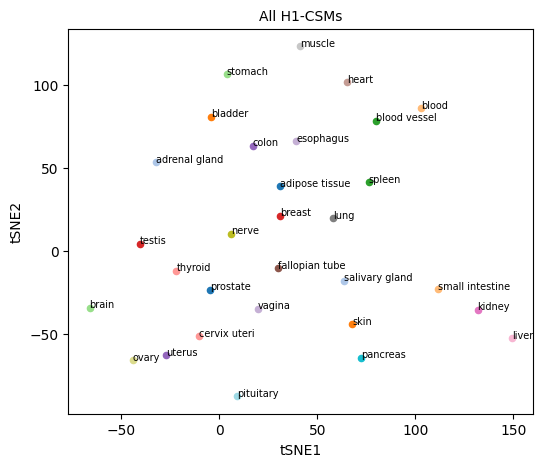

In [156]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
fig, ax = plt.subplots(figsize=(6,5)) #,sharey=True,sharex=True
# ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1]+15)
for i,t in enumerate(h1_all_tissues.index): #GRP
    ax.scatter(points_h1_all_tissues[i, 0], points_h1_all_tissues[i, 1],marker='o',label=t.title(),s=20)

ax.set_title("All H1-CSMs",fontsize="medium")    
ax.set_ylabel("tSNE2")
ax.set_xlabel("tSNE1",fontsize="medium") #,x=0.53
for i, t in enumerate(h1_all_tissues.index): 
    ax.annotate(t, (points_h1_all_tissues[i, 0], points_h1_all_tissues[i, 1]),fontsize=7)
# ax.legend(bbox_to_anchor=(1.125, -0.15),ncol=3) #bbox_to_anchor=(1.005, 1)  markerscale=1.5
plt.show()

#### Reaction content machine learning

ML setup (check gene_scoresLINUX.py):
- filter null variance genes (VarianceThreshold = 0)
- feature selection (500)
- Classification Random Forest models identifying source tissue
- average over (Cross Validation) CV=5, repeated 20x

In [118]:
#1228 sample trained models not threshold_test_local_4tissues_rin6_SC 
lcl = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","threshold_test_local_rin6_SC.csv"),header=[0,1],index_col=0)

ft_prmat_rc_ml = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","g50-90_lt50_ft212_tissue_rc_ml_nodrugex.csv"),
                          header=0,index_col=0)
tinit_prmat_rc_ml = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","g50-90_lt50_tinit212_tissue_rc_ml_nodrugex.csv"),
                          header=0,index_col=0)
ft_more_rc_ml = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","g50-90_lt50_ft53more_tissue_rc_ml_nodrugex.csv"),
                          header=0,index_col=0)
tinit_more_rc_ml = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","g50-90_lt50_tinit20more_tissue_rc_ml_nodrugex.csv"),
                          header=0,index_col=0)

ft_rc_ml = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","g50-90_lt50_allft_tissue_rc_ml_nodrugex.csv"),
                          header=0,index_col=0)
tinit_rc_ml = pd.read_csv(os.path.join(ROOT_FOLDER,"DATA","results","g50-90_lt50_alltinit_tissue_rc_ml_nodrugex.csv"),
                          header=0,index_col=0)

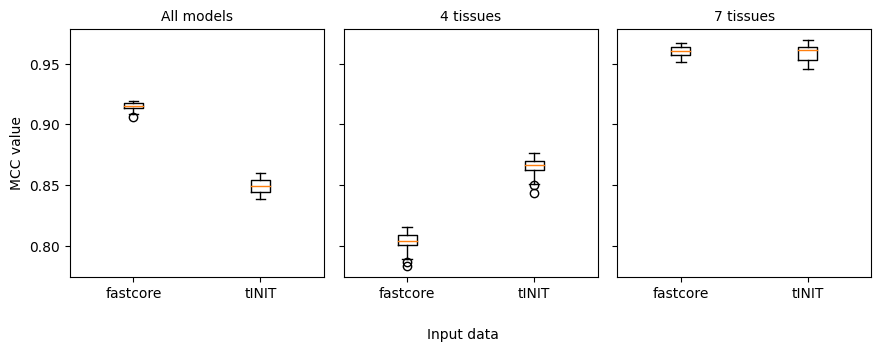

In [120]:
blue = dict(linestyle='-', linewidth=1, color='#1f77b4')
fig,ax = plt.subplots(1,3,figsize=(9,3.5),sharey=True)
ax[0].boxplot([ft_rc_ml.mean(axis=1),tinit_rc_ml.mean(axis=1)],labels=["fastcore","tINIT"]) 
# ax[1].boxplot([lcl.loc(axis=1)["0.5",'(0.5, 0.9)'],ft_prmat_rc_ml.mean(axis=1),tinit_prmat_rc_ml.mean(axis=1)],
#            labels=["Gene scores","fastcore","tINIT"])
ax[1].boxplot([ft_prmat_rc_ml.mean(axis=1),tinit_prmat_rc_ml.mean(axis=1)],
           labels=["fastcore","tINIT"])
ax[2].boxplot([ft_more_rc_ml.mean(axis=1),tinit_more_rc_ml.mean(axis=1)],labels=["fastcore","tINIT"])

ax[0].set_title("All models",fontsize="medium")
ax[1].set_title("4 tissues",fontsize="medium")
ax[2].set_title("7 tissues",fontsize="medium")
ax[0].set_ylabel("MCC value")
# ax[1].set_xlabel("Input data")
fig.supxlabel("Input data",x=0.53,fontsize="medium")
plt.tight_layout()
plt.show()

In [144]:
print("Max cross-validation average:")
print(ft_more_rc_ml.mean(axis=1).max())
print(tinit_more_rc_ml.mean(axis=1).max())
print(ft_prmat_rc_ml.mean(axis=1).max())

Max cross-validation average:
0.9665792161993124
0.9693444336443532
0.8155867648904304
